----
# **Notebook final modèles de régression**
---


# **Préambule**

Ce notebook contient le code utilisé pour obtenir nos résultats avec les modèles de régression. Il traite du nettoyage des données, de leur préparation, des méthodes de sélections des caractéristiques, de sélection des modèles et du réglage des modèles les plus performants (XGBOOST, LIGHTGBM). Se trouvent également des affichages graphiques des résultats. 

# **Imports**

In [1]:
!pip install ppscore

  Created wheel for ppscore: filename=ppscore-0.0.3-py2.py3-none-any.whl size=10303 sha256=a64267758def2a795f1759ef30afa3f13d64c86e0255ab12c7142fc65b3c5a84
  Stored in directory: /root/.cache/pip/wheels/28/ec/1a/09b55fade9bc078cde4327f2b2cfd81dcce2cda35dd91ed2e9
Successfully built ppscore


In [2]:
!pip install pycaret

     |████████████████████████████████| 194kB 2.8MB/s 
     |████████████████████████████████| 63.9MB 62kB/s 
     |████████████████████████████████| 266kB 47.9MB/s 
     |████████████████████████████████| 389kB 37.2MB/s 
     |████████████████████████████████| 7.0MB 44.2MB/s 
     |████████████████████████████████| 81kB 9.2MB/s 
     |████████████████████████████████| 61kB 8.5MB/s 
     |████████████████████████████████| 1.6MB 40.5MB/s 
     |████████████████████████████████| 1.2MB 42.4MB/s 
     |████████████████████████████████| 102kB 12.4MB/s 
     |████████████████████████████████| 133kB 48.8MB/s 
     |████████████████████████████████| 3.2MB 39.8MB/s 
     |████████████████████████████████| 71kB 9.2MB/s 
     |████████████████████████████████| 235kB 46.9MB/s 
     |████████████████████████████████| 552kB 46.0MB/s 
     |████████████████████████████████| 2.1MB 43.1MB/s 
     |████████████████████████████████| 604kB 39.6MB/s 
     |████████████████████████████████| 71kB 8.8MB/s 
  

In [3]:
# PYCARET WITH GOOGLE COLAB
from pycaret.utils import enable_colab
enable_colab()

Colab mode activated.


In [4]:
import math
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

from pycaret.regression import *

from sklearn.model_selection import StratifiedShuffleSplit

import ppscore as pps

import glob

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **Chargement des subsets, création du dataframe**

## **Code pour toute la préparation des données**

In [8]:
#              CODE FOR ALL DATA PREPARATION 

## LOADING
path = r'/content/drive/My Drive/Dataset 2/' # use your path

all_files = glob.glob(path + "*.csv")
print(all_files)

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df_concat = pd.concat(li, axis=0, ignore_index=True)

## FILTERING
cols_to_keep = ['VMOY','VMOY_latitude','VMOY_longitude',
                'distance','distance_inst','distance_latitude',
                'distance_latitude_inst','distance_longitude','distance_longitude_inst',
                'duree','duree_cumulee (h)','duree_h','event-id','ground-speed',
                'ground-speed-kmh','heading','heading_m1h','height-above-ellipsoid',
                'height-above-ellipsoid_m1h','location-lat','location-long','month',
                'tag-local-identifier','timestamp','year','TMP_surface',
                'TMP_2maboveground','TMP_1000mb','TMP_950mb','TMP_850mb','TMP_700mb',
                'UGRD_10maboveground','VGRD_10maboveground','UGRD_1000mb','VGRD_1000mb',
                'UGRD_950mb','VGRD_950mb','UGRD_850mb','VGRD_850mb','UGRD_700mb',
                'VGRD_700mb','PRES_surface','PRMSL_meansealevel','APCP_surface',
                'PRATE_surface','RH_2maboveground','RH_1000mb','RH_950mb','RH_850mb',
                'RH_700mb','Sun','day','Norme_Vent_10maboveground','Norme_Vent_1000mb',
                'Norme_Vent_950mb','Norme_Vent_850mb','Norme_Vent_700mb','Angle_Vent_10maboveground', 
                'Angle_Vent_1000mb','Angle_Vent_950mb','Angle_Vent_850mb','Angle_Vent_700mb',    
                'angle_oiseau']

df_concat = pd.DataFrame(df_concat[cols_to_keep])

### SPEED FILTERING
df_concat = df_concat[df_concat['VMOY'] >= 0] # Keeping VMOY >=0
df_concat = df_concat[df_concat['VMOY'] < 80] # Keeping VMOY < 80km/h

### FILTERING duree_h (flight duration) < 48 h
df_concat = df_concat[df_concat['duree_h'] <= 24]

### TYPE CHANGE
df_concat['Sun'] = df_concat['Sun'].astype(int)
df_concat['day'] = df_concat['day'].astype(int)

## COMPUTING FEATURES BY BIRD FOR EACH DAY

loc_lat_start = df_concat.groupby(['tag-local-identifier', 'year', 'month', 'day'], as_index=False)['location-lat'].first()[['location-lat']]
loc_long_start = df_concat.groupby(['tag-local-identifier', 'year', 'month', 'day'], as_index=False)['location-long'].first()[['location-long']]

loc_lat_end = df_concat.groupby(['tag-local-identifier', 'year', 'month', 'day'], as_index=False)['location-lat'].last()[['location-lat']]
loc_long_end = df_concat.groupby(['tag-local-identifier', 'year', 'month', 'day'], as_index=False)['location-long'].last()[['location-long']]


cols_to_aggregate = {"VMOY": "mean", 
                     "TMP_surface": "mean",
                     "TMP_700mb": "mean",
                     "UGRD_10maboveground": "mean",
                     "VGRD_10maboveground": "mean", 
                     "UGRD_700mb": "mean",
                     "VGRD_700mb": "mean",
                     "PRES_surface": "mean",
                     "PRMSL_meansealevel": "mean",
                     "PRATE_surface": "sum",
                     "RH_2maboveground": "mean", 
                     "Norme_Vent_10maboveground": "mean",
                     "Norme_Vent_700mb": "mean",
                     "Angle_Vent_10maboveground": "mean",
                     "Angle_Vent_700mb": "mean",
                     "angle_oiseau": "mean"}
                    #  "duree_h": "sum"
                    #  'TMP_2maboveground': "mean", 
                    #  'TMP_1000mb': "mean", 
                    #  'TMP_950mb': "mean", 
                    #  'TMP_850mb': "mean",
                    #  'UGRD_1000mb': "mean", 
                    #  'VGRD_1000mb': "mean", 
                    #  'UGRD_950mb': "mean", 
                    #  'VGRD_950mb': "mean",
                    #  'UGRD_850mb': "mean", 
                    #  'VGRD_850mb': "mean",
                    #  'APCP_surface': "mean",
                    #  'RH_1000mb': "mean", 
                    #  'RH_950mb': "mean",
                    #  'RH_850mb': "mean", 
                    #  'RH_700mb': "mean",
                     
df_concat = df_concat.groupby(['tag-local-identifier', 'year', 'month', 'day'], as_index=False).agg(cols_to_aggregate)

df_concat['location-lat-start'] = loc_lat_start
df_concat['location-long-start'] = loc_long_start

df_concat['location-lat-end'] = loc_lat_end
df_concat['location-long-end'] = loc_long_end

print("\nNombre d'oiseaux contenus dans le jeu de données : ", df_concat['tag-local-identifier'].nunique())

## KEEPING 1 BIRDS IN 2019 MIGRATIONS AND REMOVING IT FROM DATASET + COLs RENAMING
df_concat[df_concat['year']==2019]['tag-local-identifier'].unique()
df_concat_2019 = df_concat[df_concat['year']==2019]
df_bird_1 = df_concat_2019[df_concat_2019['tag-local-identifier']==2561][:500]
df_bird_1 = df_bird_1.rename(columns={"angle_oiseau": "cap_oiseau"})

df_concat = df_concat.drop(df_bird_1.index)
df_concat = df_concat.drop(['tag-local-identifier', 'year', 'day'], axis=1)
df_concat = df_concat.rename(columns={"angle_oiseau": "cap_oiseau"})

## DISPLAYING SOME INFORMATIONS
print("\nTaille du jeu de données constituée : ", df_concat.shape)

print("\nColonnes et types associés :\n", df_concat.dtypes)

['/content/drive/My Drive/Dataset 2/2019_2_Stork.csv', '/content/drive/My Drive/Dataset 2/2016_2_Stork.csv', '/content/drive/My Drive/Dataset 2/2019_1_Stork.csv', '/content/drive/My Drive/Dataset 2/2017_1_Stork.csv', '/content/drive/My Drive/Dataset 2/2018_2_Stork.csv', '/content/drive/My Drive/Dataset 2/2018_1_Stork.csv', '/content/drive/My Drive/Dataset 2/2017_2_Stork.csv']

Nombre d'oiseaux contenus dans le jeu de données :  105

Taille du jeu de données constituée :  (41732, 21)

Colonnes et types associés : 
 month                          int64
VMOY                         float64
TMP_surface                  float64
TMP_700mb                    float64
UGRD_10maboveground          float64
VGRD_10maboveground          float64
UGRD_700mb                   float64
VGRD_700mb                   float64
PRES_surface                 float64
PRMSL_meansealevel           float64
PRATE_surface                float64
RH_2maboveground             float64
Norme_Vent_10maboveground    float64

## **Code pour la préparation des données avec détails des investigations**
Cette partie permet de mieux comprendre le code retenu dans la partie précédente. 

In [9]:
path = r'/content/drive/My Drive/Dataset 2/' # use your path

all_files = glob.glob(path + "*.csv")
print(all_files)

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df_concat = pd.concat(li, axis=0, ignore_index=True)

['/content/drive/My Drive/Dataset 2/2019_2_Stork.csv', '/content/drive/My Drive/Dataset 2/2016_2_Stork.csv', '/content/drive/My Drive/Dataset 2/2019_1_Stork.csv', '/content/drive/My Drive/Dataset 2/2017_1_Stork.csv', '/content/drive/My Drive/Dataset 2/2018_2_Stork.csv', '/content/drive/My Drive/Dataset 2/2018_1_Stork.csv', '/content/drive/My Drive/Dataset 2/2017_2_Stork.csv']


In [10]:
df_concat.shape

(780473, 146)

In [11]:
print(df_concat.isnull().sum().to_string())

Unnamed: 0                                0
VMOY                                      1
VMOY_latitude                             1
VMOY_longitude                            1
angle_oiseau                              0
day                                       0
distance                                  0
distance_inst                             0
distance_latitude                         0
distance_latitude_inst                    0
distance_longitude                        0
distance_longitude_inst                   0
duree                                     0
duree_cumulee (h)                         0
duree_h                                   0
event-id                                  0
ground-speed                              0
ground-speed-kmh                          0
heading                                   0
heading_m1h                               0
height-above-ellipsoid                    0
height-above-ellipsoid_1                  0
height-above-ellipsoid_2        

In [12]:
cols_to_keep = ['VMOY','VMOY_latitude','VMOY_longitude',
                'distance','distance_inst','distance_latitude',
                'distance_latitude_inst','distance_longitude','distance_longitude_inst',
                'duree','duree_cumulee (h)','duree_h','event-id','ground-speed',
                'ground-speed-kmh','heading','heading_m1h','height-above-ellipsoid',
                'height-above-ellipsoid_m1h','location-lat','location-long','month',
                'tag-local-identifier','timestamp','year','TMP_surface',
                'TMP_2maboveground','TMP_1000mb','TMP_950mb','TMP_850mb','TMP_700mb',
                'UGRD_10maboveground','VGRD_10maboveground','UGRD_1000mb','VGRD_1000mb',
                'UGRD_950mb','VGRD_950mb','UGRD_850mb','VGRD_850mb','UGRD_700mb',
                'VGRD_700mb','PRES_surface','PRMSL_meansealevel','APCP_surface',
                'PRATE_surface','RH_2maboveground','RH_1000mb','RH_950mb','RH_850mb',
                'RH_700mb','Sun','day','Norme_Vent_10maboveground','Norme_Vent_1000mb',
                'Norme_Vent_950mb','Norme_Vent_850mb','Norme_Vent_700mb','Angle_Vent_10maboveground', 
                'Angle_Vent_1000mb','Angle_Vent_950mb','Angle_Vent_850mb','Angle_Vent_700mb',    
                'angle_oiseau']

df_concat = pd.DataFrame(df_concat[cols_to_keep])

In [13]:
df_concat.shape

(780473, 63)

In [14]:
print(df_concat.dtypes.to_string())

VMOY                          float64
VMOY_latitude                 float64
VMOY_longitude                float64
distance                      float64
distance_inst                 float64
distance_latitude             float64
distance_latitude_inst        float64
distance_longitude            float64
distance_longitude_inst       float64
duree                         float64
duree_cumulee (h)             float64
duree_h                       float64
event-id                        int64
ground-speed                  float64
ground-speed-kmh              float64
heading                       float64
heading_m1h                   float64
height-above-ellipsoid        float64
height-above-ellipsoid_m1h    float64
location-lat                  float64
location-long                 float64
month                           int64
tag-local-identifier            int64
timestamp                      object
year                            int64
TMP_surface                   float64
TMP_2maboveg

In [15]:
print(df_concat.isnull().sum().to_string())

VMOY                            1
VMOY_latitude                   1
VMOY_longitude                  1
distance                        0
distance_inst                   0
distance_latitude               0
distance_latitude_inst          0
distance_longitude              0
distance_longitude_inst         0
duree                           0
duree_cumulee (h)               0
duree_h                         0
event-id                        0
ground-speed                    0
ground-speed-kmh                0
heading                         0
heading_m1h                     0
height-above-ellipsoid          0
height-above-ellipsoid_m1h      0
location-lat                    0
location-long                   0
month                           0
tag-local-identifier            0
timestamp                       0
year                            0
TMP_surface                   346
TMP_2maboveground             346
TMP_1000mb                    346
TMP_950mb                     346
TMP_850mb     

In [16]:
df_concat = df_concat.dropna().reset_index(drop=True)
df_concat.shape

(779783, 63)

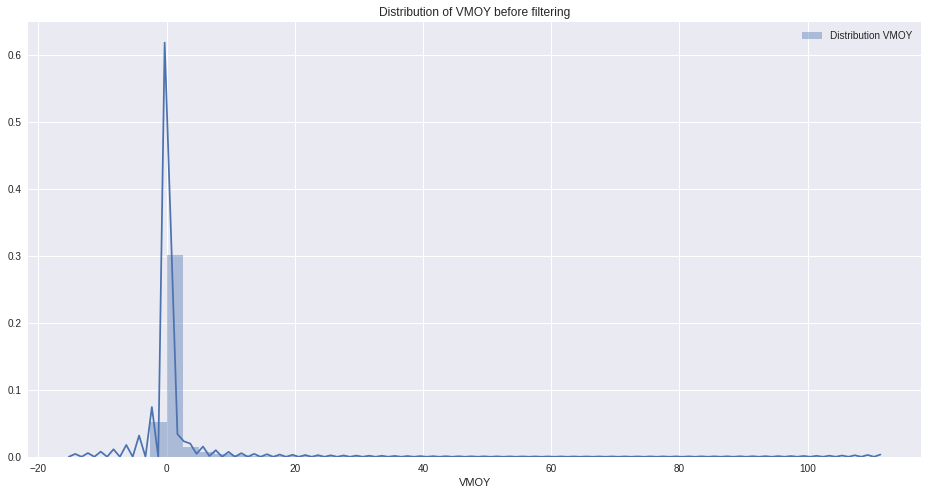

In [17]:
plt.figure(figsize=(16,8))
sns.distplot(df_concat['VMOY'], norm_hist=True, label='Distribution VMOY')
plt.title("Distribution of VMOY before filtering")
plt.legend()
plt.show()

In [18]:
### SPEED FILTERING
df_concat = df_concat[df_concat['VMOY'] >= 0] # On garde les VMOY >=0
df_concat = df_concat[df_concat['VMOY'] < 80] # On garde les VMOY < 80km/h

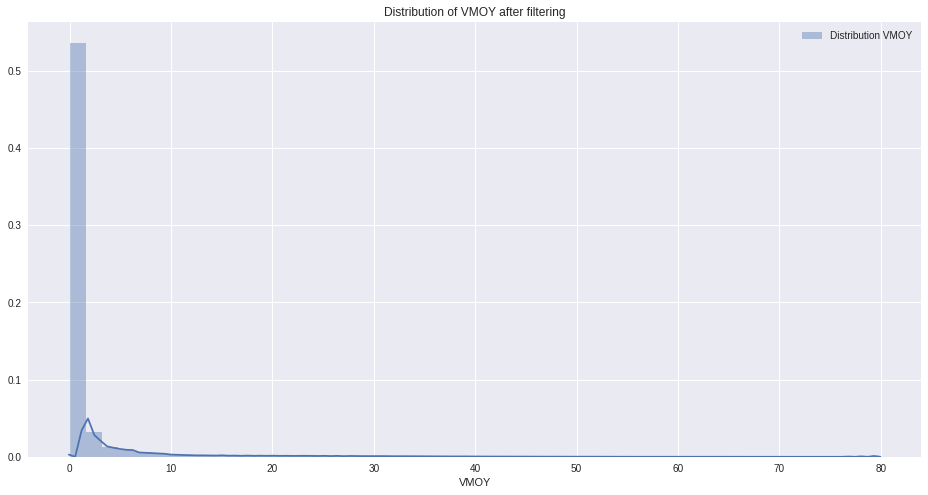

In [19]:
plt.figure(figsize=(16,8))
sns.distplot(df_concat['VMOY'], norm_hist=True, label='Distribution VMOY')
plt.title("Distribution of VMOY after filtering")
plt.legend()
plt.show()

In [20]:
df_concat[['duree_h']].describe()

,duree_h
count,779633.000000
mean,2.952371
std,36.913121
min,0.000556
25%,0.999444
50%,1.000000
75%,1.001111
max,4127.004167


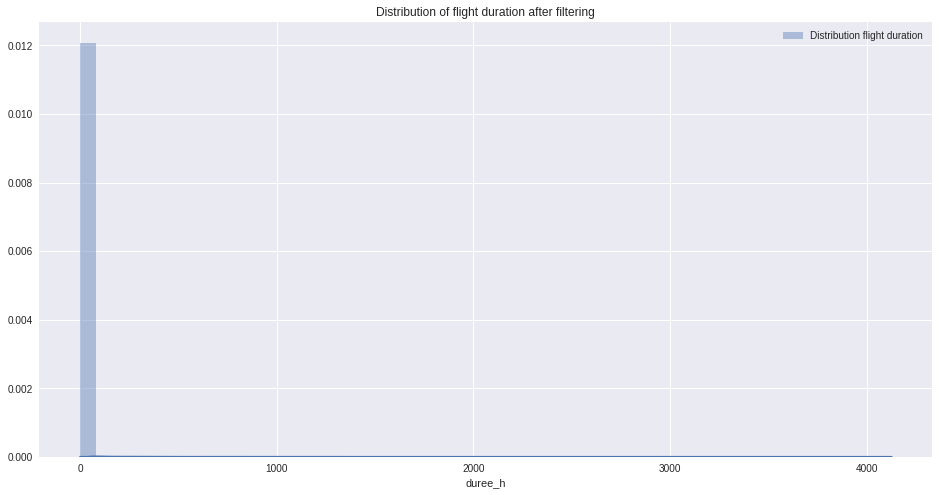

In [21]:
plt.figure(figsize=(16,8))
sns.distplot(df_concat['duree_h'], norm_hist=True, label='Distribution flight duration')
plt.title("Distribution of flight duration after filtering")
plt.legend()
plt.show()

In [22]:
## FILTERING duree_h (flight duration) < 48 h
df_concat = df_concat[df_concat['duree_h'] <= 24]

In [23]:
df_concat[['duree_h']].describe()

,duree_h
count,776066.000000
mean,1.412930
std,1.787881
min,0.000556
25%,0.999444
50%,1.000000
75%,1.000834
max,24.000000


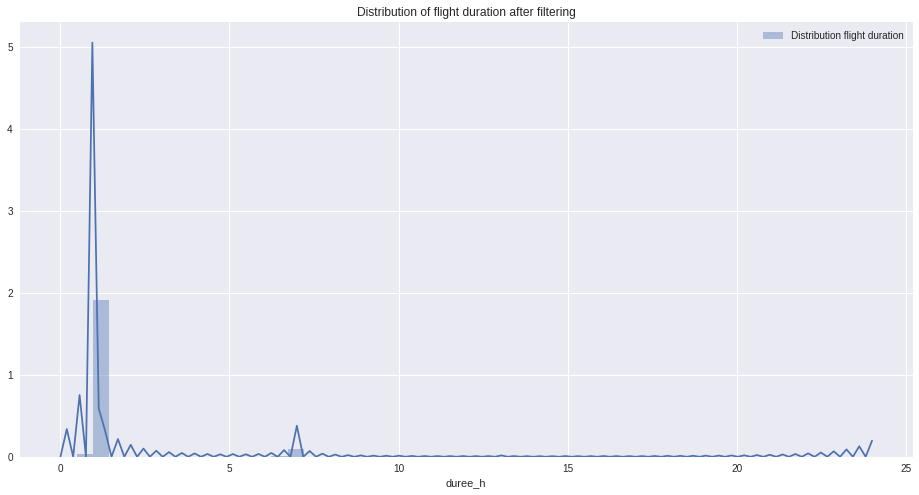

In [25]:
plt.figure(figsize=(16,8))
sns.distplot(df_concat['duree_h'], norm_hist=True, label='Distribution flight duration')
plt.title("Distribution of flight duration after filtering")
plt.legend()
plt.show()

In [26]:
df_concat['Sun'] = df_concat['Sun'].astype(int)
df_concat['day'] = df_concat['day'].astype(int)

In [27]:
df_concat.dtypes

VMOY                 float64
VMOY_latitude        float64
VMOY_longitude       float64
distance             float64
distance_inst        float64
                      ...   
Angle_Vent_1000mb    float64
Angle_Vent_950mb     float64
Angle_Vent_850mb     float64
Angle_Vent_700mb     float64
angle_oiseau         float64
Length: 63, dtype: object

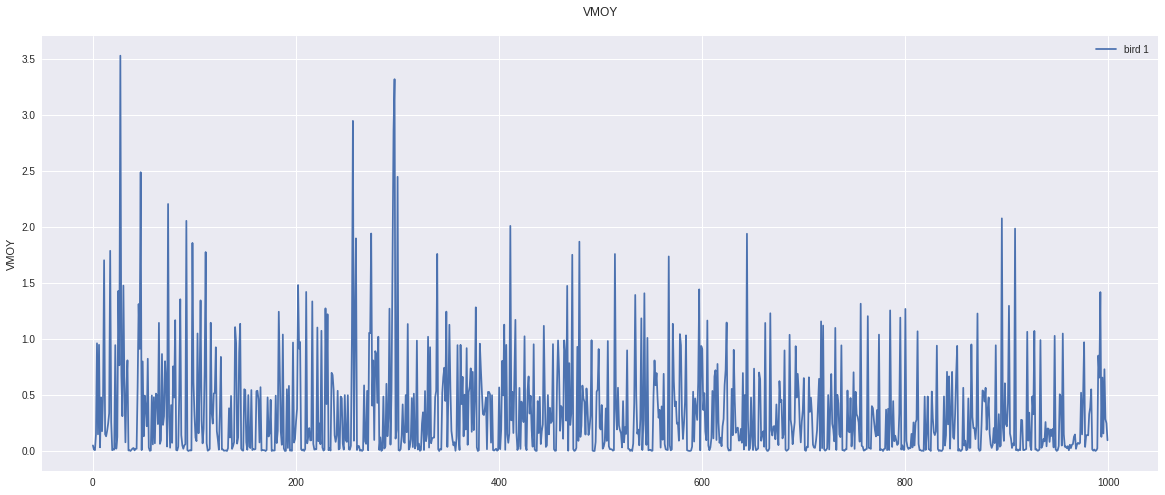

In [28]:
plt.figure(figsize=(20,8))
sns.lineplot(range(1000), df_concat['VMOY'].iloc[:1000], label='bird 1') 
# sns.lineplot(range(315), df_bird_2['VMOY'], label='bird 2') 
# sns.lineplot(range(315), df_bird_3['VMOY'], label='bird 3') 
plt.title("VMOY\n")
plt.show()

In [29]:
### COMPUTING FEATURES BY BIRD FOR EACH DAY

loc_lat_start = df_concat.groupby(['tag-local-identifier', 'year', 'month', 'day'], as_index=False)['location-lat'].first()[['location-lat']]
loc_long_start = df_concat.groupby(['tag-local-identifier', 'year', 'month', 'day'], as_index=False)['location-long'].first()[['location-long']]

loc_lat_end = df_concat.groupby(['tag-local-identifier', 'year', 'month', 'day'], as_index=False)['location-lat'].last()[['location-lat']]
loc_long_end = df_concat.groupby(['tag-local-identifier', 'year', 'month', 'day'], as_index=False)['location-long'].last()[['location-long']]


cols_to_aggregate = {"VMOY": "mean", 
                     "TMP_surface": "mean",
                     "TMP_700mb": "mean",
                     "UGRD_10maboveground": "mean",
                     "VGRD_10maboveground": "mean", 
                     "UGRD_700mb": "mean",
                     "VGRD_700mb": "mean",
                     "PRES_surface": "mean",
                     "PRMSL_meansealevel": "mean",
                     "PRATE_surface": "sum",
                     "RH_2maboveground": "mean", 
                     "Norme_Vent_10maboveground": "mean",
                     "Norme_Vent_700mb": "mean",
                     "Angle_Vent_10maboveground": "mean",
                     "Angle_Vent_700mb": "mean",
                     "angle_oiseau": "mean"}
                    #  "duree_h": "sum"
                    #  'TMP_2maboveground': "mean", 
                    #  'TMP_1000mb': "mean", 
                    #  'TMP_950mb': "mean", 
                    #  'TMP_850mb': "mean",
                    #  'UGRD_1000mb': "mean", 
                    #  'VGRD_1000mb': "mean", 
                    #  'UGRD_950mb': "mean", 
                    #  'VGRD_950mb': "mean",
                    #  'UGRD_850mb': "mean", 
                    #  'VGRD_850mb': "mean",
                    #  'APCP_surface': "mean",
                    #  'RH_1000mb': "mean", 
                    #  'RH_950mb': "mean",
                    #  'RH_850mb': "mean", 
                    #  'RH_700mb': "mean",
                     
df_concat = df_concat.groupby(['tag-local-identifier', 'year', 'month', 'day'], as_index=False).agg(cols_to_aggregate)

df_concat['location-lat-start'] = loc_lat_start
df_concat['location-long-start'] = loc_long_start

df_concat['location-lat-end'] = loc_lat_end
df_concat['location-long-end'] = loc_long_end

df_concat

,tag-local-identifier,year,month,day,VMOY,TMP_surface,TMP_700mb,UGRD_10maboveground,VGRD_10maboveground,UGRD_700mb,VGRD_700mb,PRES_surface,PRMSL_meansealevel,PRATE_surface,RH_2maboveground,Norme_Vent_10maboveground,Norme_Vent_700mb,Angle_Vent_10maboveground,Angle_Vent_700mb,angle_oiseau,location-lat-start,location-long-start,location-lat-end,location-long-end
0,2541,2016,7,1,0.511718,285.399994,283.200012,1.370000,0.320000,3.760000,1.930000,76777.328125,101507.851562,0.004427,95.300003,1.406876,4.226405,124.384198,138.408289,201.236956,47.751273,8.933175,47.751195,8.933138
1,2541,2016,7,2,0.373940,285.399994,283.200012,1.370000,0.320000,3.760000,1.930000,76777.328125,101507.851562,0.004427,95.300003,1.406876,4.226405,122.764680,136.788771,199.617438,47.751094,8.933058,47.751040,8.933179
2,2541,2016,7,3,0.797027,285.399994,283.200012,1.370000,0.320000,3.760000,1.930000,76777.328125,101507.851562,0.004427,95.300003,1.406876,4.226405,104.740992,118.765083,181.593750,47.751311,8.933034,47.751235,8.933044
3,2541,2016,7,4,0.347094,285.399994,283.200012,1.370000,0.320000,3.760000,1.930000,76777.328125,101507.851562,0.004427,95.300003,1.406876,4.226405,83.142247,97.166337,159.995005,47.751196,8.933108,47.751165,8.933266
4,2541,2016,7,5,0.214185,285.399994,283.200012,1.370000,0.320000,3.760000,1.930000,76777.328125,101507.851562,0.004427,95.300003,1.406876,4.226405,69.356540,83.380631,146.209298,47.750967,8.932423,47.751217,8.933149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42021,7207,2019,12,4,2.181324,296.459726,283.244738,-0.703833,-0.956173,-6.489093,-2.650824,96784.001850,101099.348067,0.000000,27.210526,1.190297,7.020383,49.978087,80.710285,192.872846,14.667645,-15.576342,14.455539,-15.642014
42022,7207,2019,12,5,1.456375,296.683411,283.200012,-0.757517,-1.153015,-6.515935,-2.283982,96982.273438,101102.140625,0.000000,27.299999,1.379593,6.904635,-13.404405,23.974448,133.291162,14.455534,-15.642032,14.438528,-15.595257
42023,7207,2019,12,6,4.928239,296.604463,283.215798,-0.738570,-1.083541,-6.506461,-2.413456,96912.295230,101101.155016,0.000000,27.268420,1.312783,6.945487,55.576390,90.609365,200.930495,14.444753,-15.575380,14.605796,-15.533051
42024,7207,2019,12,7,1.746529,296.683411,283.200012,-0.757517,-1.153015,-6.515935,-2.283982,96982.273438,101102.140625,0.000000,27.299999,1.379593,6.904635,22.538561,59.917414,169.234128,14.599835,-15.525280,14.512346,-15.480321


In [30]:
df_concat['tag-local-identifier'].nunique()

105

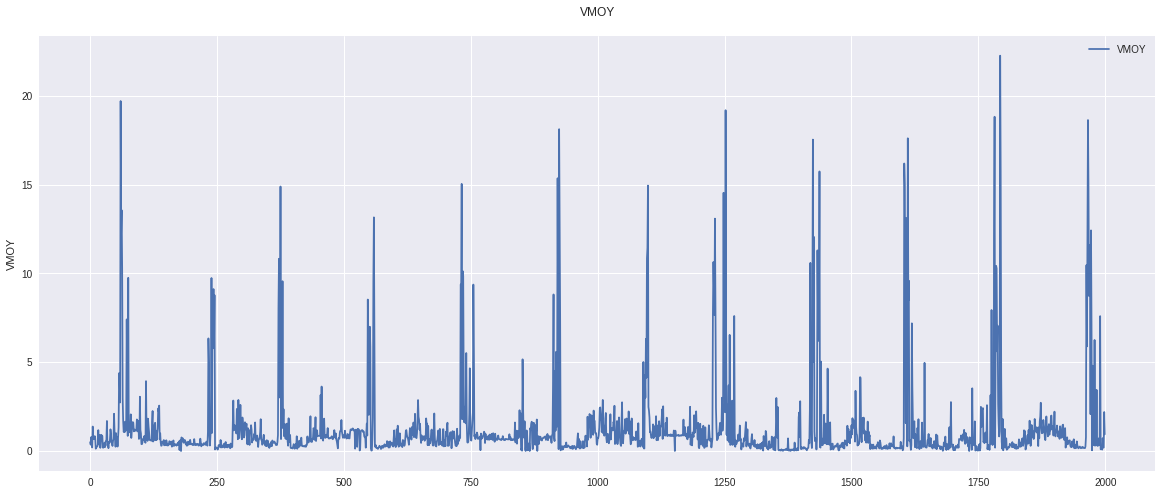

In [31]:
plt.figure(figsize=(20,8))
sns.lineplot(range(2000), df_concat['VMOY'].iloc[:2000], label='VMOY') 
# sns.lineplot(range(315), df_bird_2['VMOY'], label='bird 2') 
# sns.lineplot(range(315), df_bird_3['VMOY'], label='bird 3') 
plt.title("VMOY\n")
plt.show()

In [32]:
### KEEPING 1 BIRDS IN 2019 MIGRATIONS
df_concat[df_concat['year']==2019]['tag-local-identifier'].unique()

array([2541, 2543, 2561, 2665, 3024, 3027, 3029, 3064, 3170, 3264, 3907,
       3921, 3941, 3963, 3984, 3992, 3994, 3996, 4001, 4004, 4347, 4354,
       4355, 4360, 4363, 4364, 4408, 5526, 5527, 5944, 5945, 6377, 6379,
       6380, 6381, 6382, 6383, 6385, 6386, 6586, 6592, 6593, 6982, 6988,
       6990, 6993, 6995, 6996, 7032, 7200, 7203, 7204, 7205, 7206, 7207])

In [33]:
df_concat_2019 = df_concat[df_concat['year']==2019]
df_bird_1 = df_concat_2019[df_concat_2019['tag-local-identifier']==2561][:500]
df_bird_1 = df_bird_1.rename(columns={"angle_oiseau": "cap_oiseau"})
# df_bird_2 = df_concat_2019[df_concat_2019['tag-local-identifier']==4364][:500]
# df_bird_3 = df_concat_2019[df_concat_2019['tag-local-identifier']==3170][:500]
df_bird_1.shape

(315, 24)

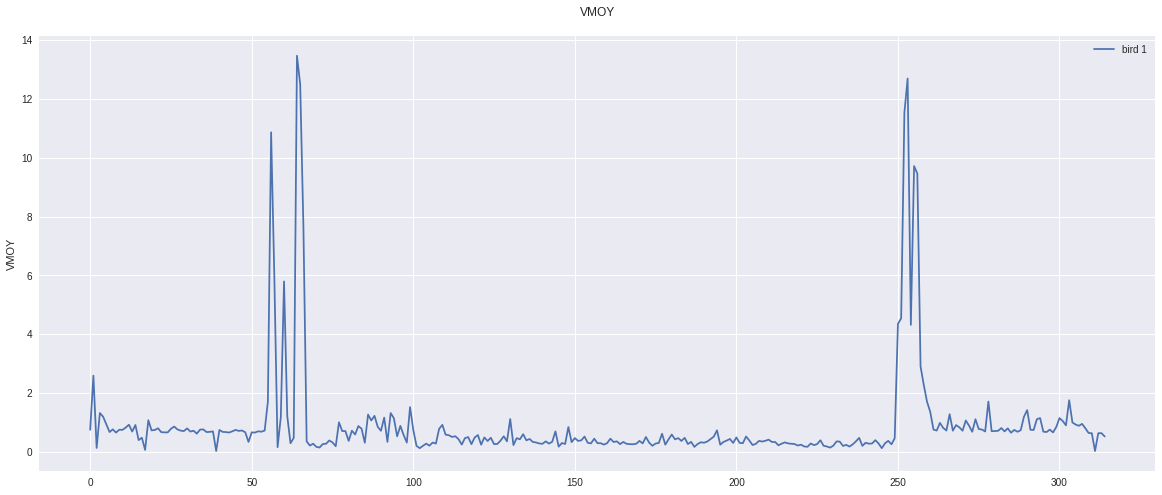

In [34]:
plt.figure(figsize=(20,8))
sns.lineplot(range(315), df_bird_1['VMOY'], label='bird 1') 
# sns.lineplot(range(315), df_bird_2['VMOY'], label='bird 2') 
# sns.lineplot(range(315), df_bird_3['VMOY'], label='bird 3') 
plt.title("VMOY\n")
plt.show()

In [35]:
df_concat.shape

(42026, 24)

In [36]:
df_concat = df_concat.drop(df_bird_1.index)
# df_concat = df_concat.drop(df_bird_2.index)
# df_concat = df_concat.drop(df_bird_3.index)
df_concat = df_concat.drop(['tag-local-identifier', 'year', 'day'], axis=1)
df_concat = df_concat.rename(columns={"angle_oiseau": "cap_oiseau"})
df_concat.shape

(41711, 21)

In [37]:
print(df_concat.isnull().sum().to_string())

month                        0
VMOY                         0
TMP_surface                  0
TMP_700mb                    0
UGRD_10maboveground          0
VGRD_10maboveground          0
UGRD_700mb                   0
VGRD_700mb                   0
PRES_surface                 0
PRMSL_meansealevel           0
PRATE_surface                0
RH_2maboveground             0
Norme_Vent_10maboveground    0
Norme_Vent_700mb             0
Angle_Vent_10maboveground    0
Angle_Vent_700mb             0
cap_oiseau                   0
location-lat-start           0
location-long-start          0
location-lat-end             0
location-long-end            0


In [38]:
df_concat.dtypes

month                          int64
VMOY                         float64
TMP_surface                  float64
TMP_700mb                    float64
UGRD_10maboveground          float64
VGRD_10maboveground          float64
UGRD_700mb                   float64
VGRD_700mb                   float64
PRES_surface                 float64
PRMSL_meansealevel           float64
PRATE_surface                float64
RH_2maboveground             float64
Norme_Vent_10maboveground    float64
Norme_Vent_700mb             float64
Angle_Vent_10maboveground    float64
Angle_Vent_700mb             float64
cap_oiseau                   float64
location-lat-start           float64
location-long-start          float64
location-lat-end             float64
location-long-end            float64
dtype: object

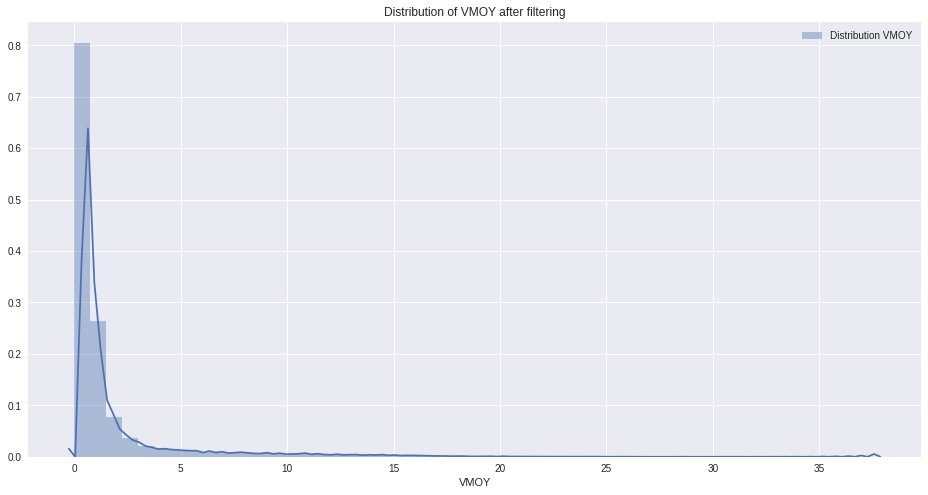

In [39]:
plt.figure(figsize=(16,8))
sns.distplot(df_concat['VMOY'], norm_hist=True, label='Distribution VMOY')
plt.title("Distribution of VMOY after filtering")
plt.legend()
plt.show()

## **Predictive Power Score and Correlation Matrix** (*Ne pas relancer exécution*)

Attention, peut prendre du temps à calculer selon le nombre de colonnes.

In [ ]:
df_pps_matrix = pps.matrix(df_concat.drop(['month'], axis=1))

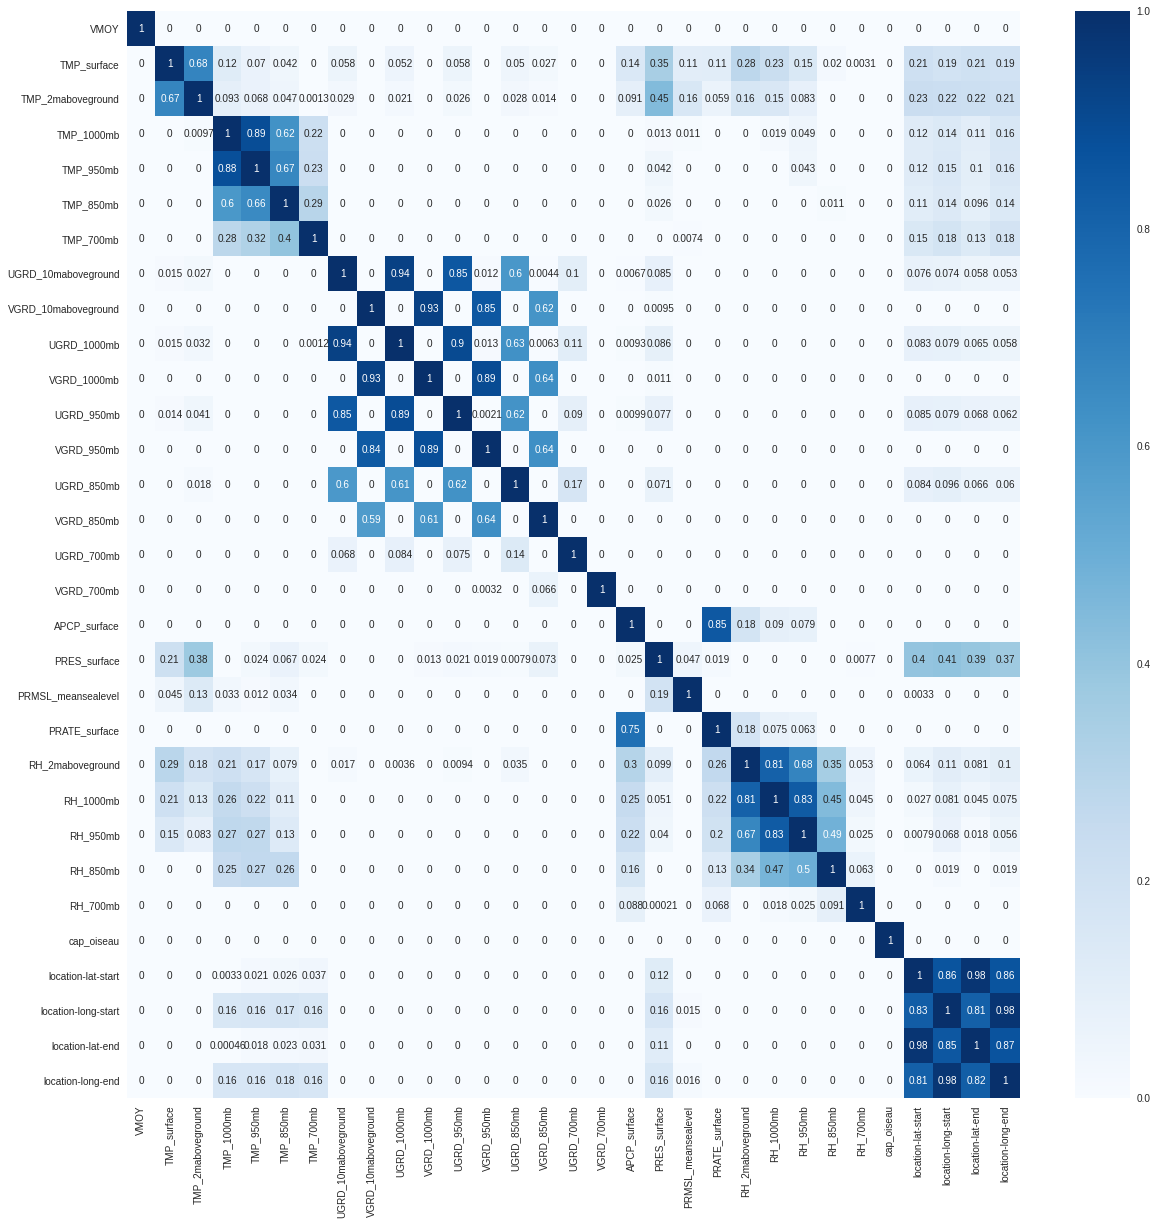

In [ ]:
plt.figure(figsize=(20,20))
ax = sns.heatmap(df_pps_matrix, vmin=0, vmax=1, cmap="Blues", annot=True)

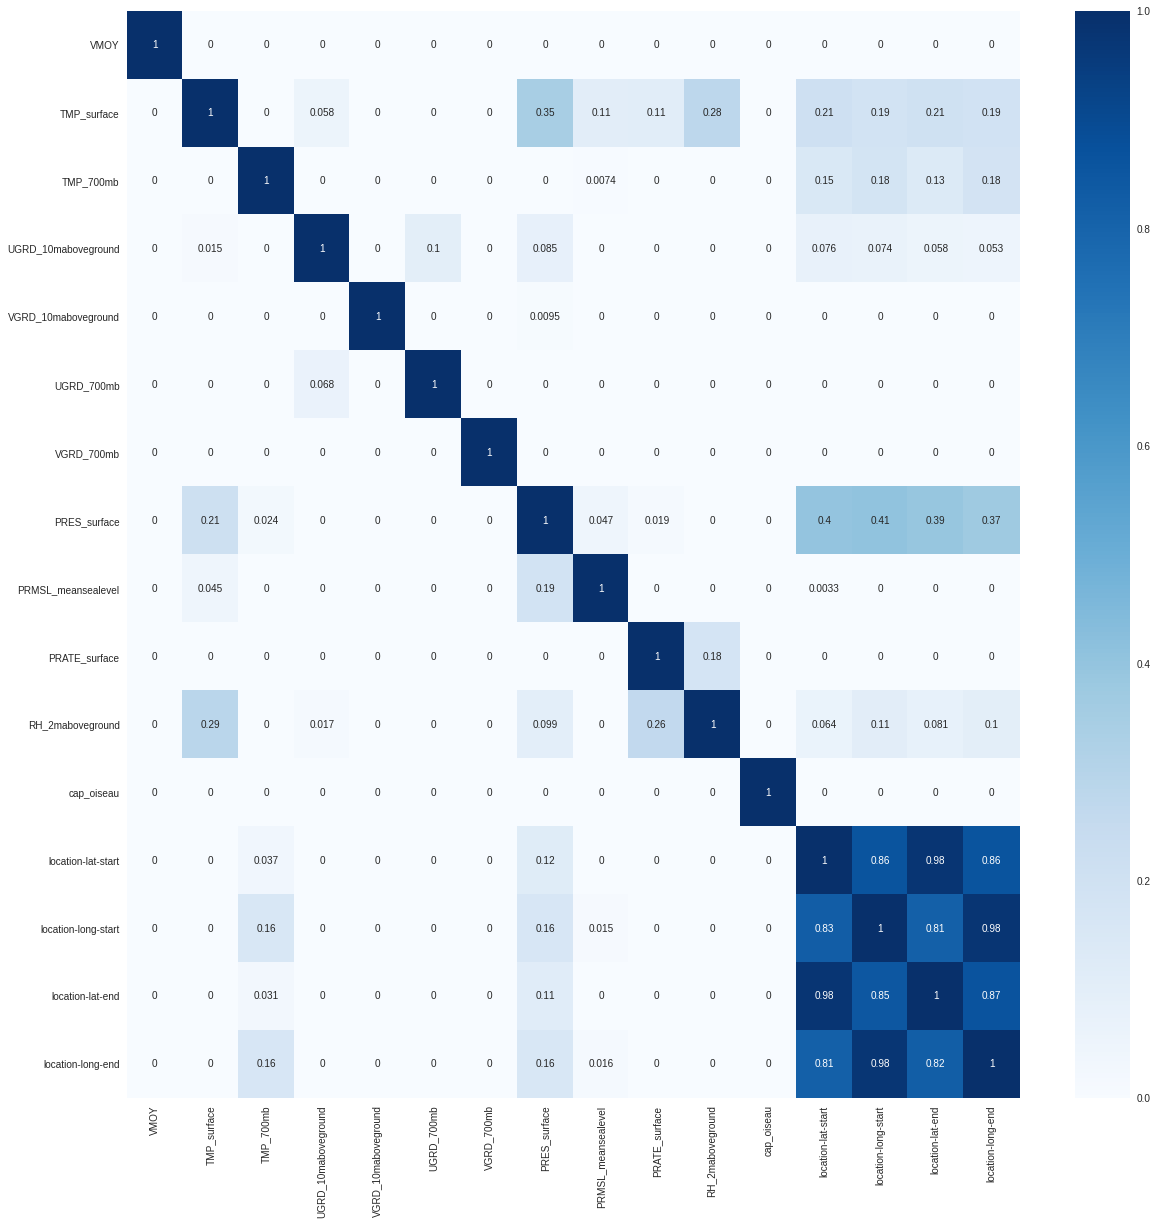

In [ ]:
plt.figure(figsize=(20,20))
ax = sns.heatmap(df_pps_matrix, vmin=0, vmax=1, cmap="Blues", annot=True)

In [ ]:
# Compute the correlation matrix
corr = df_concat.drop(['month'], axis=1).corr()

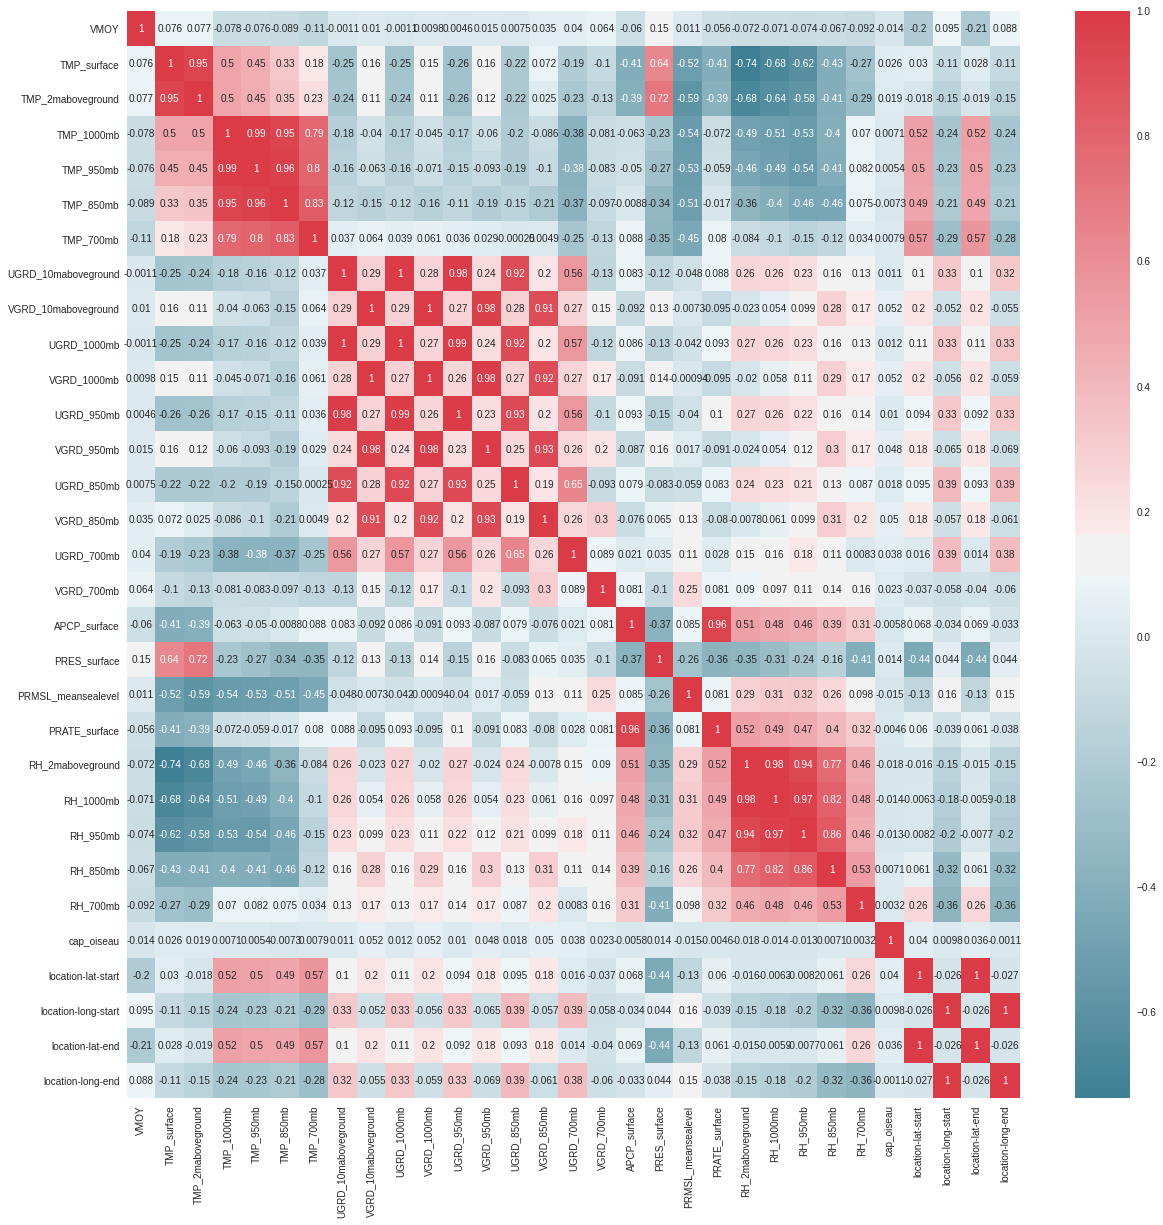

In [ ]:
plt.figure(figsize=(20,20))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax = sns.heatmap(corr, cmap=cmap, annot=True)

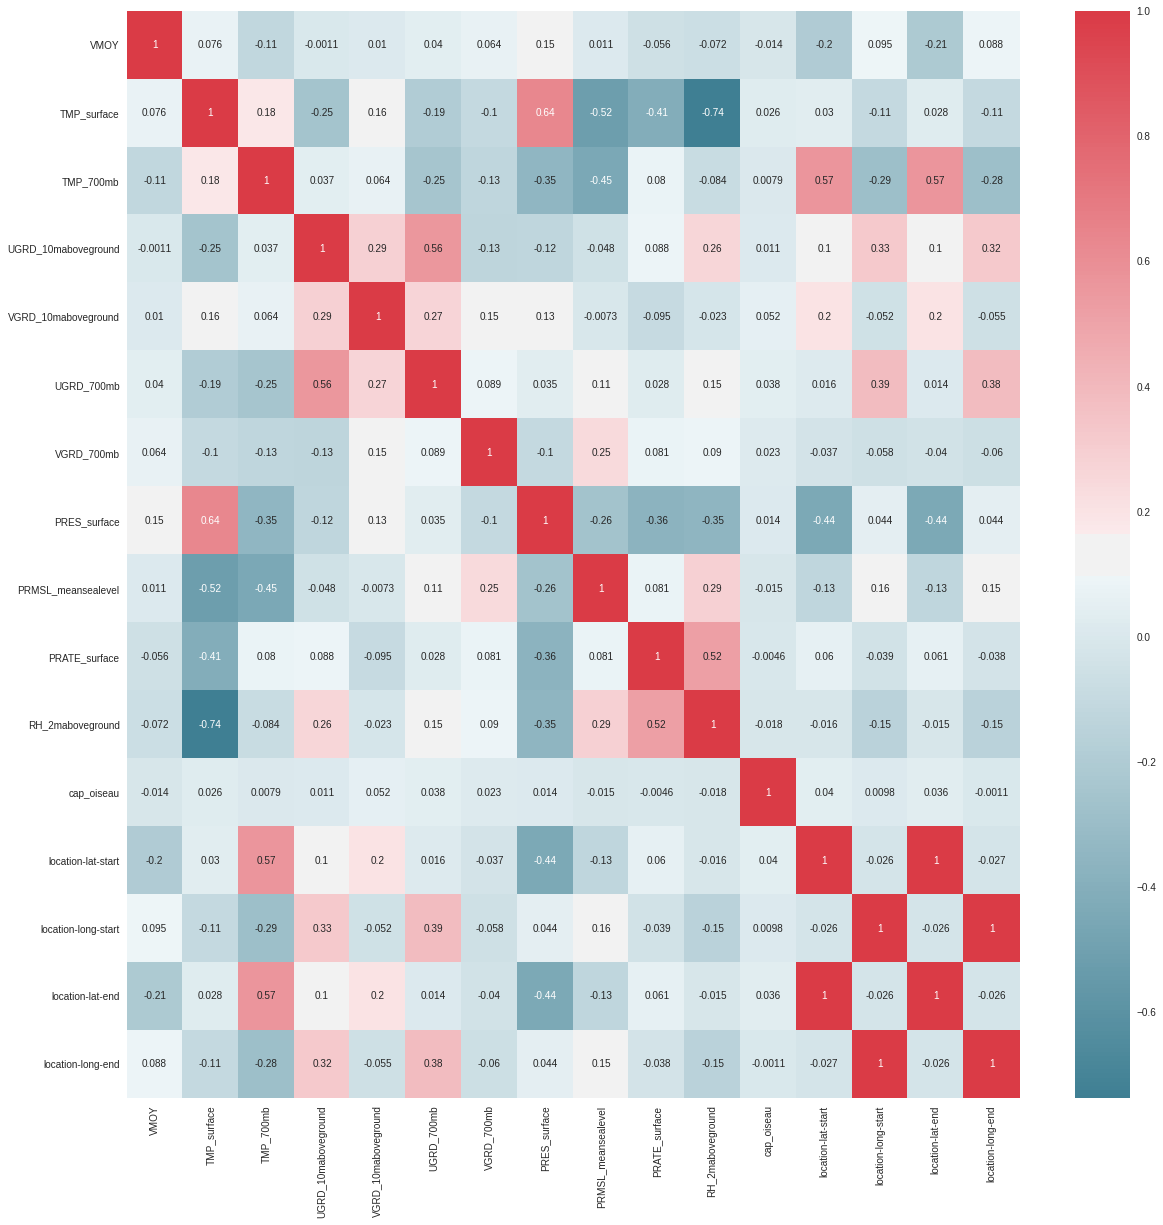

In [ ]:
plt.figure(figsize=(20,20))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax = sns.heatmap(corr, cmap=cmap, annot=True)

# **Modèles de regression**

https://pycaret.org/

https://pycaret.org/regression/

https://github.com/pycaret/pycaret/blob/master/Tutorials/Regression%20Tutorial%20Level%20Beginner%20-%20REG101.ipynb


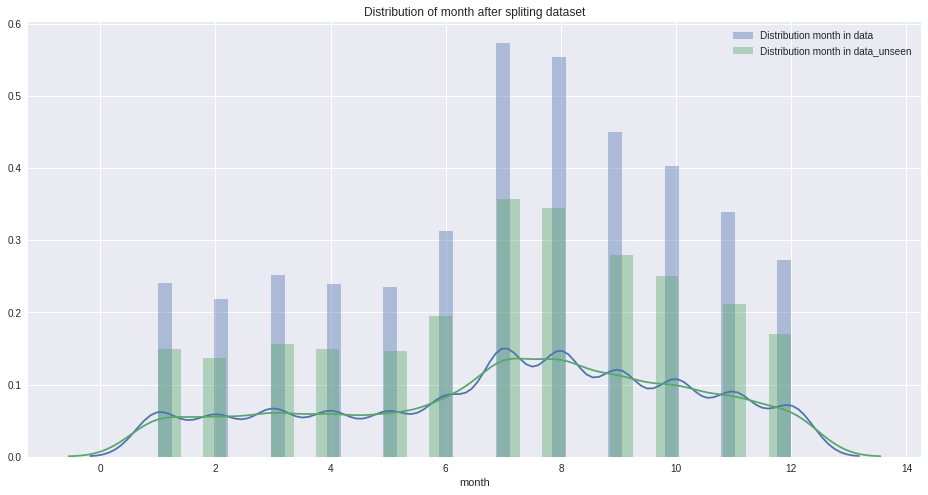


Data for Modeling: (33368, 16)
Unseen Data For Predictions (8343, 16)


In [ ]:
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=786)

for train_index, test_index in stratified_split.split(df_concat, df_concat['month']):
    data = df_concat.iloc[train_index].reset_index(drop=True)
    data_unseen = df_concat.iloc[test_index].reset_index(drop=True)

plt.figure(figsize=(16,8))
sns.distplot(data['month'], norm_hist=True, label='Distribution month in data')
sns.distplot(data_unseen['month'], norm_hist=True, label='Distribution month in data_unseen')
plt.title("Distribution of month after spliting dataset")
plt.legend()
plt.show()

data = data.drop(['month', 'Norme_Vent_10maboveground',	'Norme_Vent_700mb',	
                  'Angle_Vent_10maboveground', 'Angle_Vent_700mb'], axis=1)
data_unseen = data_unseen.drop(['month', 'Norme_Vent_10maboveground',	'Norme_Vent_700mb',	
                                'Angle_Vent_10maboveground', 'Angle_Vent_700mb'], axis=1)

print()
print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions ' + str(data_unseen.shape))

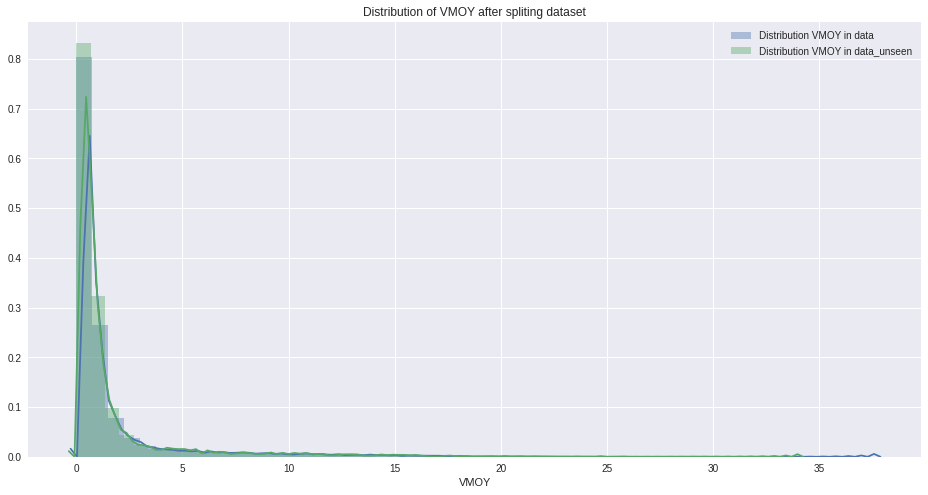

In [ ]:
plt.figure(figsize=(16,8))
sns.distplot(data['VMOY'], norm_hist=True, label='Distribution VMOY in data')
sns.distplot(data_unseen['VMOY'], norm_hist=True, label='Distribution VMOY in data_unseen')
plt.title("Distribution of VMOY after spliting dataset")
plt.legend()
plt.show()

## **Configuration de l'environnement PyCaret**
Cette étape permet de préparer les données pour les utiliser avec la bibliothèque Pycaret. Beaucoup d'options sont possibles mais nous prenons ici une configuration simple pour réaliser des comparaisons brutes entre les grand modèles de regression.

Plus d'informations sur les options possibles : https://pycaret.org/regression/ et https://pycaret.org/preprocessing/

In [ ]:
from pycaret.regression import *

In [ ]:
exp_reg103 = setup(data = data, target = 'VMOY', session_id=125, train_size=0.7)

 
Setup Succesfully Completed!


,Description,Value
0,session_id,125
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(33481, 16)"
4,Missing Values,False
5,Numeric Features,15
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


## **Comparaison entre modèles**

Comparing all models to evaluate performance is the recommended starting point for modeling once the setup is completed (unless you exactly know what kind of model you need, which is often not the case). This function trains all models in the model library and scores them using k-fold cross validation for metric evaluation. The output prints a score grid that shows average MAE, MSE, RMSE, R2, RMSLE and MAPE accross the folds (10 by default) of all the available models in the model library.


| Estimator	| Abbreviated String |
|---|---|
| Linear Regression |	‘lr’ |
| Lasso Regression |	‘lasso’ |
| Ridge Regression |	‘ridge’ |
| Elastic Net |	‘en’ |
| Least Angle Regression |	‘lar’ |
| Lasso Least Angle Regression |	‘llar’ |
| Orthogonal Matching Pursuit	| ‘omp’ |
| Bayesian Ridge |	‘br’ |
| Automatic Relevance Determination |	‘ard’ |
| Passive Aggressive Regressor |	‘par’ |
| Random Sample Consensus |	‘ransac’ |
| TheilSen Regressor |	‘tr’ |
| Huber Regressor |	‘huber’ |
| Kernel Ridge |	‘kr’ |
| Support Vector Machine |	‘svm’ |
| K Neighbors Regressor |	‘knn’ |
| Decision Tree |	‘dt’ |
| Random Forest |	‘rf’ |
| Extra Trees Regressor |	‘et’ |
| AdaBoost Regressor |	‘ada’ |
| Gradient Boosting Regressor | ‘gbr’ |
| Multi Level Perceptron |	‘mlp’ |
| Extreme Gradient Boosting	| ‘xgboost’ |
| Light Gradient Boosting |	‘lightgbm’ |
| CatBoost Regressor |	‘catboost’ |



In [ ]:
not_to_test = ['huber', 'tr', 'svm'] # 

compare_models(sort = 'MAE', blacklist = not_to_test, fold = 5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.937700,3.283500,1.811400,0.602000,0.436900,9.838300
1,Random Forest,0.944400,3.490700,1.867300,0.577200,0.447500,10.047300
2,CatBoost Regressor,1.094300,4.086500,2.020600,0.504400,0.500300,13.601900
3,Light Gradient Boosting Machine,1.097500,4.309200,2.074600,0.477900,0.501700,14.007700
4,Decision Tree,1.173400,6.635600,2.574800,0.195500,0.580400,7.945700
5,Gradient Boosting Regressor,1.260600,5.456600,2.335000,0.338700,0.555700,15.796500
6,Extreme Gradient Boosting,1.262700,5.471100,2.337900,0.337100,0.556300,16.027200
7,K Neighbors Regressor,1.318700,7.504600,2.738200,0.090600,0.607200,9.115500
8,Passive Aggressive Regressor,1.419100,8.737800,2.952300,-0.059500,0.650300,9.870400
9,Random Sample Consensus,1.451400,7.765200,2.785500,0.059200,0.636100,15.585300


## **Création et réglage des modèles XGBOOST et LIGHTGBM**

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
#from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import xgboost
from xgboost import XGBRegressor

import lightgbm
from lightgbm import LGBMRegressor

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.drop('VMOY', axis=1), data['VMOY'], test_size=0.2, random_state=42)

In [ ]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

# A parameter grid for XGBoost
params = {
        'min_child_weight': [2, 5, 7, 8],
        'gamma': [1, 1.5, 2, 3, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.4, 0.6, 0.8, 1.0],
        'n_estimators': [800, 900, 1000],
        'max_depth': [12, 14, 16]
        }

###  Historique XGBOOST
# Best hyperparameters:
# {'subsample': 0.8, 'n_estimators': 500, 'min_child_weight': 7, 'max_depth': 10, 'gamma': 1.5, 'colsample_bytree': 0.6}

#  Best hyperparameters:
# {'subsample': 0.6, 'n_estimators': 700, 'min_child_weight': 5, 'max_depth': 12, 'gamma': 2, 'colsample_bytree': 0.8}

# Best hyperparameters:
# {'subsample': 0.6, 'n_estimators': 1000, 'min_child_weight': 7, 'max_depth': 14, 'gamma': 2, 'colsample_bytree': 0.8}



###  Historique LightGBM
# Best hyperparameters:
# {'subsample': 0.6, 'n_estimators': 700, 'min_child_weight': 5, 'max_depth': 12, 'gamma': 2, 'colsample_bytree': 0.8}

# Best hyperparameters:
# {'subsample': 0.8, 'n_estimators': 700, 'min_child_weight': 5, 'max_depth': 10, 'gamma': 1, 'colsample_bytree': 1.0}

#  Best hyperparameters:
# {'subsample': 0.6, 'n_estimators': 800, 'min_child_weight': 5, 'max_depth': 12, 'gamma': 2, 'colsample_bytree': 0.8}

# Best hyperparameters:
# {'subsample': 0.6, 'n_estimators': 900, 'min_child_weight': 5, 'max_depth': 14, 'gamma': 2, 'colsample_bytree': 0.8}

# Best hyperparameters:
# {'subsample': 1.0, 'n_estimators': 1000, 'min_child_weight': 7, 'max_depth': 14, 'gamma': 1.5, 'colsample_bytree': 0.8}

In [ ]:
xgboost_reg = XGBRegressor(objective='reg:squarederror', verbose=True,
                  learning_rate=0.05, n_jobs=-1) #booster='gbtree', tree_method='gpu_hist'

In [ ]:
lightgbm_reg = LGBMRegressor(objective='regression', verbose=10,
                  learning_rate=0.05, n_jobs=-1) #booster='gbtree', tree_method='gpu_hist'

In [ ]:
# XGBOOST

# Best hyperparameters:
# {'subsample': 1.0, 'n_estimators': 1000, 'min_child_weight': 7, 'max_depth': 12, 'gamma': 1.5, 'colsample_bytree': 1.0}

params = {
        'min_child_weight': [7],
        'gamma': [1.5],
        'subsample': [0.8], #0.8
        'colsample_bytree': [1.0], #0.8
        'n_estimators': [1000],
        'max_depth': [12]
        }

folds = 10 
param_comb = 1

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 42)

random_search_xgb = RandomizedSearchCV(xgboost_reg, param_distributions=params, n_iter=param_comb, 
                                  scoring='neg_mean_squared_error', n_jobs=-1, cv=10, verbose=10, random_state=125)

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search_xgb.fit(X_train, y_train)
timer(start_time) # timing ends here for "start_time" variable

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 14.9min finished



 Time taken: 0 hours 16 minutes and 35.63 seconds.


In [ ]:
print('\n All results: XGBoost')
print(random_search_xgb.cv_results_)
print('\n Best estimator:')
print(random_search_xgb.best_estimator_)
print('\n Best mean squared error score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search_xgb.best_score_ ) #* 2 - 1
print('\n Best hyperparameters:')
print(random_search_xgb.best_params_)
results_xgb = pd.DataFrame(random_search_xgb.cv_results_)
results_xgb.to_csv('xgb-random-grid-search-results-01.csv', index=False)


 All results: XGBoost
{'mean_fit_time': array([177.20593803]), 'std_fit_time': array([0.71660615]), 'mean_score_time': array([0.72228153]), 'std_score_time': array([0.02618817]), 'param_subsample': masked_array(data=[0.8],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[1000],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_min_child_weight': masked_array(data=[7],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[12],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_gamma': masked_array(data=[1.5],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_colsample_bytree': masked_array(data=[1.0],
             mask=[False],
       fill_value='?',
            dtype=object), 'params': [{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 7, 'max_dep

In [ ]:
# LIGHTGBM

folds = 10 
param_comb = 10

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 42)

random_search_lgbm = RandomizedSearchCV(lightgbm_reg, param_distributions=params, n_iter=param_comb, 
                                  scoring='neg_mean_squared_error', n_jobs=-1, cv=10, verbose=10, random_state=125)

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search_lgbm.fit(X_train, y_train)
timer(start_time) # timing ends here for "start_time" variable

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   51.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.7min finished



 Time taken: 0 hours 5 minutes and 45.99 seconds.


In [ ]:
print('\n All results: LightGBM')
print(random_search_lgbm.cv_results_)
print('\n Best estimator:')
print(random_search_lgbm.best_estimator_)
print('\n Best mean squared error score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search_lgbm.best_score_ ) #* 2 - 1
print('\n Best hyperparameters:')
print(random_search_lgbm.best_params_)
results_lgbm = pd.DataFrame(random_search_lgbm.cv_results_)
results_lgbm.to_csv('lightgbm-random-grid-search-results-01.csv', index=False)


 All results: LightGBM
{'mean_fit_time': array([7.17037601, 5.56408429, 7.33997812, 8.07604675, 6.70890381,
       5.67602239, 8.09961746, 6.75759904, 4.58560755, 4.30638275]), 'std_fit_time': array([0.4836034 , 0.17113917, 0.16158623, 0.25242202, 0.21497884,
       0.22867488, 0.14053017, 0.22496061, 0.17630689, 0.32149853]), 'mean_score_time': array([0.34971778, 0.2713074 , 0.33214502, 0.3797184 , 0.29444005,
       0.31198862, 0.36720679, 0.28701353, 0.29639702, 0.40028949]), 'std_score_time': array([0.02640018, 0.02379686, 0.0164584 , 0.0163861 , 0.01408019,
       0.02006882, 0.02634659, 0.01068908, 0.01639025, 0.05379983]), 'param_subsample': masked_array(data=[1.0, 0.8, 1.0, 1.0, 0.8, 0.6, 0.6, 0.8, 0.6, 0.8],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[1000, 800, 900, 1000, 800, 800, 1000, 800, 800, 1000],
             mask

In [ ]:
# Training a classifier with the best parameters
xgb_reg = random_search_xgb.best_estimator_  

## Re-Processing train test split if wanted
# xtrain_cv, xtest_cv, ytrain_cv, ytest_cv = train_test_split(xtrain, ytrain, test_size=0.3, random_state=42)

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
xgb_reg.fit(data.drop('VMOY', axis=1), data['VMOY']) # X_train, y_train
timer(start_time) # timing ends here for "start_time" variable


 Time taken: 0 hours 2 minutes and 10.8 seconds.


In [ ]:
# Training a classifier with the best parameters
lgbm_reg = random_search_lgbm.best_estimator_  

## Re-Processing train test split if wanted
# xtrain_cv, xtest_cv, ytrain_cv, ytest_cv = train_test_split(xtrain, ytrain, test_size=0.3, random_state=42)

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
lgbm_reg.fit(X_train, y_train)
timer(start_time) # timing ends here for "start_time" variable


 Time taken: 0 hours 0 minutes and 4.48 seconds.


### **Importance des caractéristiques**

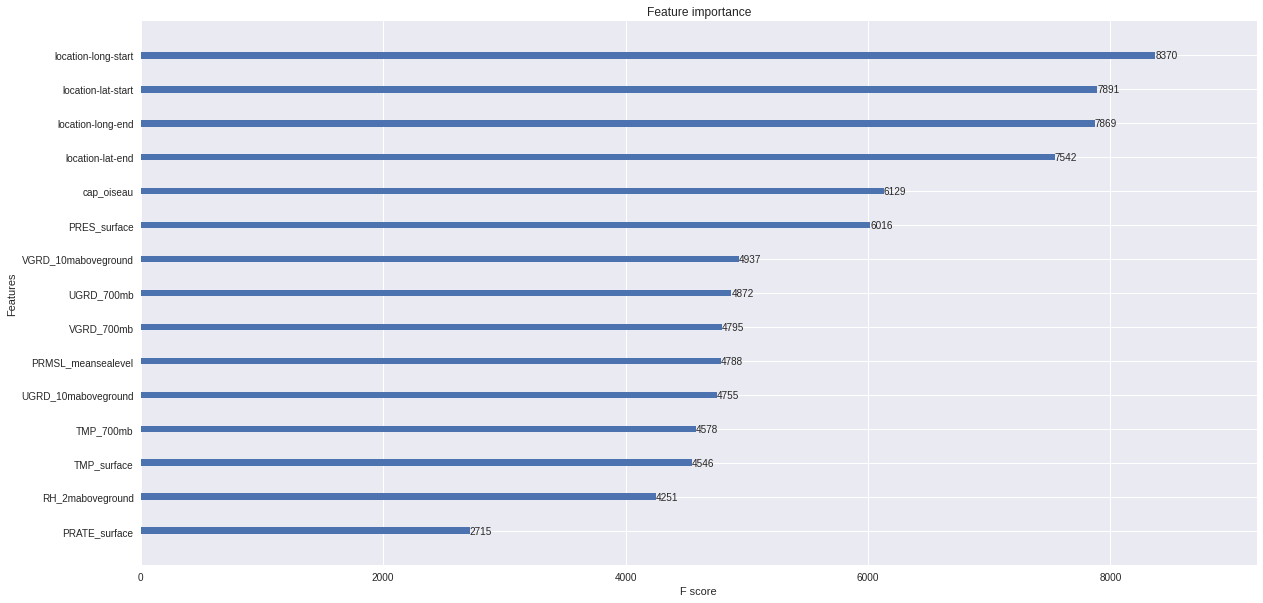

In [ ]:
# Ploting the feature importance XGBOOST
xgboost.plot_importance(xgb_reg)
plt.rcParams['figure.figsize'] = [20, 10]
plt.show()

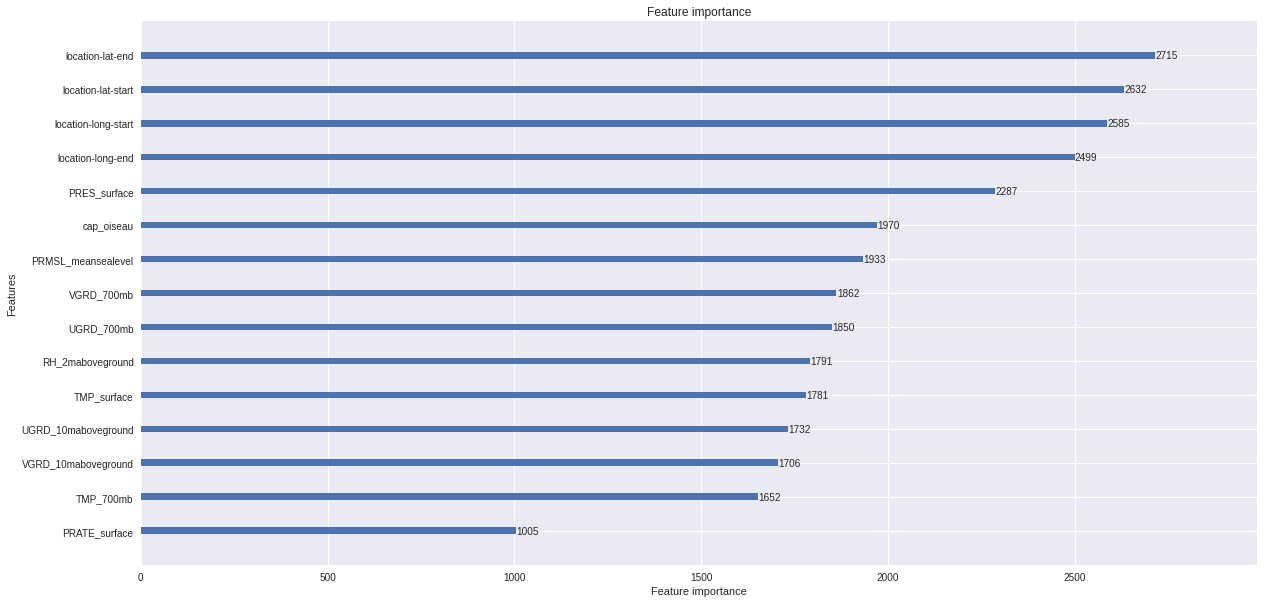

In [ ]:
# Ploting the feature importance LIGHTGBM
lightgbm.plot_importance(lgbm_reg)
plt.rcParams['figure.figsize'] = [20, 10]
plt.show()

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.853796 to fit


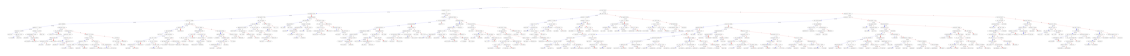

In [ ]:
xgboost.plot_tree(xgb_reg,num_trees=0)
plt.show()

In [ ]:
lightgbm.plot_tree(lgbm_reg,num_trees=0)
plt.show()

 ### **Calcul des prédictions**

Sur données de test

In [ ]:
y_pred_xgb = pd.DataFrame(xgb_reg.predict(X_test))
y_pred_xgb

,0
0,0.493455
1,0.619685
2,1.627548
3,0.446995
4,0.108075
...,...
6669,0.798687
6670,-0.012260
6671,1.316564
6672,0.722855


In [ ]:
y_pred_lgbm = pd.DataFrame(lgbm_reg.predict(X_test))
y_pred_lgbm

,0
0,0.743278
1,0.496472
2,0.742186
3,1.169055
4,0.516455
...,...
6692,3.297080
6693,0.832314
6694,0.654935
6695,0.646310


In [ ]:
data_unseen[['VMOY']].describe()

,VMOY
count,8343.000000
mean,1.491779
std,2.863484
min,0.000874
25%,0.255814
50%,0.574806
75%,1.174598
max,33.891601


Sur données non vues

In [ ]:
y_pred_xgb_unseen = pd.DataFrame(xgb_reg.predict(data_unseen.drop('VMOY', axis=1)))
y_pred_xgb_unseen.describe()

,0
count,8343.000000
mean,1.459603
std,2.411004
min,-0.677162
25%,0.459222
50%,0.738322
75%,1.196882
max,19.418604


In [ ]:
y_pred_lgbm_unseen = pd.DataFrame(lgbm_reg.predict(data_unseen.drop('VMOY', axis=1)))
y_pred_lgbm_unseen.describe()

,0
count,8371.000000
mean,1.467051
std,2.347311
min,-1.562266
25%,0.523938
50%,0.760014
75%,1.219015
max,20.748646


### **Scores XGBOOST**

Sur données de test (avant ré-entraînement du modèle sur `data`).

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mae = mean_absolute_error(y_test, y_pred_xgb)
mse = mean_squared_error(y_test, y_pred_xgb)
r2 = r2_score(y_test, y_pred_xgb)
print("MAE: %f" % (mae))
print("MSE: %f" % (mse))
print("R2: %f" % (r2))

MAE: 0.658185
MSE: 1.761241
R2: 0.787367


Sur données non vues.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mae = mean_absolute_error(data_unseen['VMOY'], y_pred_xgb_unseen)
mse = mean_squared_error(data_unseen['VMOY'], y_pred_xgb_unseen)
r2 = r2_score(data_unseen['VMOY'], y_pred_xgb_unseen)
print("MAE: %f" % (mae))
print("MSE: %f" % (mse))
print("R2: %f" % (r2))

MAE: 0.624623
MSE: 1.595761
R2: 0.805361


### **Scores LIGHTGBM**

Sur données de test (avant ré-entraînement du modèle sur `data`).

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mae = mean_absolute_error(y_test, y_pred_lgbm)
mse = mean_squared_error(y_test, y_pred_lgbm)
r2 = r2_score(y_test, y_pred_lgbm)
print("MAE: %f" % (mae))
print("MSE: %f" % (mse))
print("R2: %f" % (r2))

MAE: 0.759166
MSE: 2.129520
R2: 0.745070


Sur données non vues.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mae = mean_absolute_error(data_unseen['VMOY'], y_pred_lgbm_unseen)
mse = mean_squared_error(data_unseen['VMOY'], y_pred_lgbm_unseen)
r2 = r2_score(data_unseen['VMOY'], y_pred_lgbm_unseen)
print("MAE: %f" % (mae))
print("MSE: %f" % (mse))
print("R2: %f" % (r2))

MAE: 0.747048
MSE: 2.192829
R2: 0.746787


In [ ]:
y_pred_xgb.describe()

,0
count,6674.000000
mean,1.458950
std,2.395029
min,-1.193347
25%,0.480564
50%,0.749276
75%,1.214957
max,23.659132


In [ ]:
y_pred_lgbm.describe()

,0
count,6697.000000
mean,1.483496
std,2.317635
min,-1.678302
25%,0.523147
50%,0.770220
75%,1.259619
max,20.450760


In [ ]:
y_test = pd.DataFrame(y_test)
y_test.describe()

,VMOY
count,6674.000000
mean,1.496392
std,2.878240
min,0.000841
25%,0.261446
50%,0.589981
75%,1.186055
max,26.064159


### **Affichage graphique des résultats**

XGBOOST

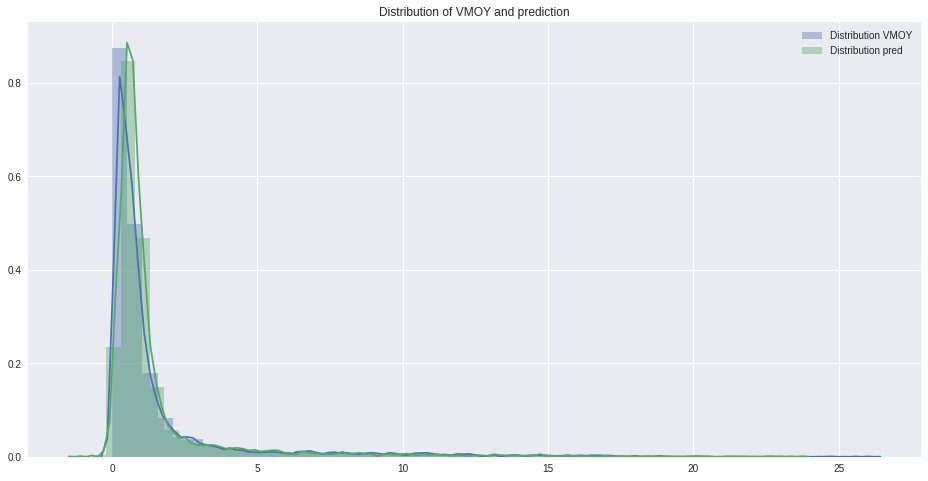

In [ ]:
plt.figure(figsize=(16,8))
sns.distplot(y_test, norm_hist=True, label='Distribution VMOY')
sns.distplot(y_pred_xgb, norm_hist=True, label='Distribution pred')
plt.title("Distribution of VMOY and prediction")
plt.legend()
plt.show()

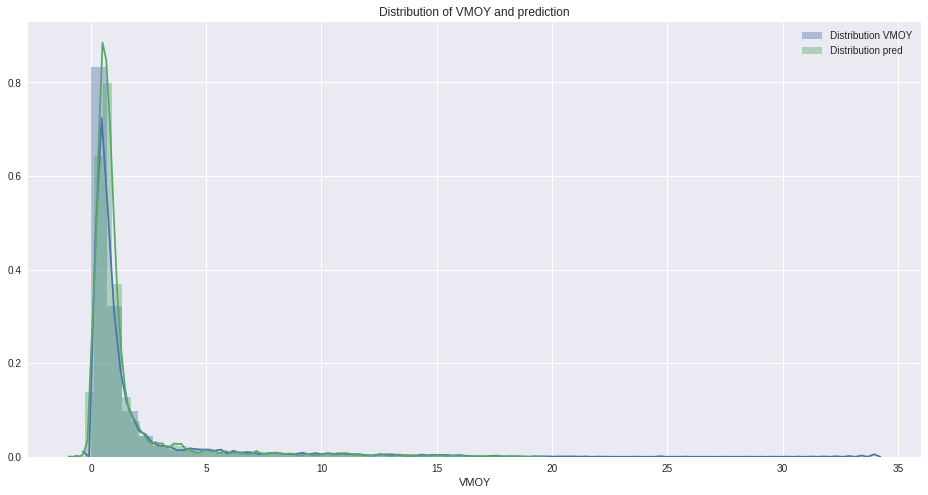

In [ ]:
plt.figure(figsize=(16,8))
sns.distplot(data_unseen['VMOY'], norm_hist=True, label='Distribution VMOY')
sns.distplot(y_pred_xgb_unseen, norm_hist=True, label='Distribution pred')
plt.title("Distribution of VMOY and prediction")
plt.legend()
plt.show()

LIGHTGBM

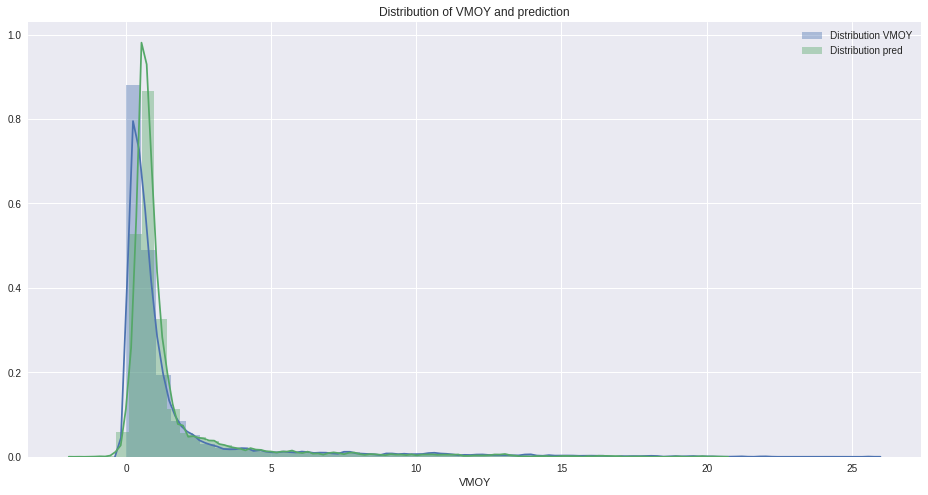

In [ ]:
plt.figure(figsize=(16,8))
sns.distplot(y_test, norm_hist=True, label='Distribution VMOY')
sns.distplot(y_pred_lgbm, norm_hist=True, label='Distribution pred')
plt.title("Distribution of VMOY and prediction")
plt.legend()
plt.show()

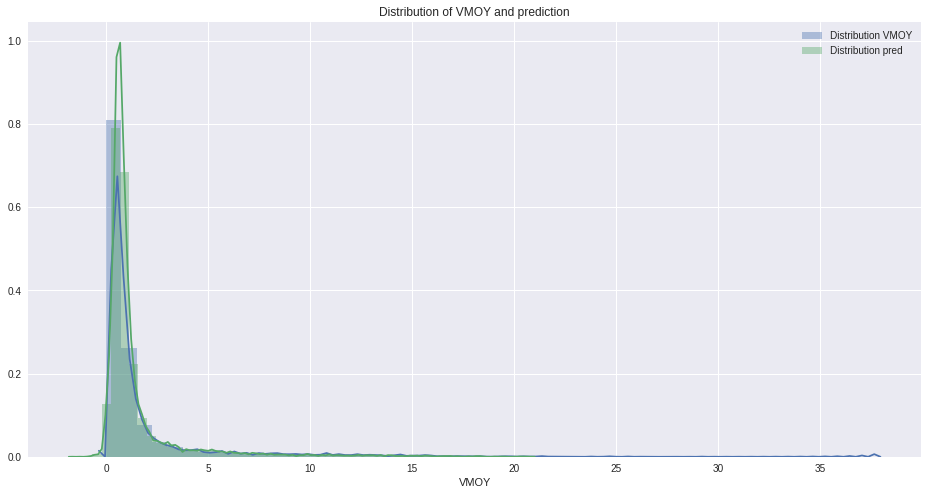

In [ ]:
plt.figure(figsize=(16,8))
sns.distplot(data_unseen['VMOY'], norm_hist=True, label='Distribution VMOY')
sns.distplot(y_pred_lgbm_unseen, norm_hist=True, label='Distribution pred')
plt.title("Distribution of VMOY and prediction")
plt.legend()
plt.show()

XGBOOST

In [ ]:
pred_bird_1_xgb = pd.DataFrame(xgb_reg.predict(df_bird_1.drop(['VMOY', 'tag-local-identifier', 'year', 'month', 'day', 
                                                                 'Norme_Vent_10maboveground',	'Norme_Vent_700mb',	
                                                                 'Angle_Vent_10maboveground', 'Angle_Vent_700mb'], axis=1)))
# pred_bird_2 = predict_model(model, data=df_bird_2)
# pred_bird_3 = predict_model(model, data=df_bird_3)

pred_bird_1_xgb.describe()

,0
count,315.000000
mean,1.009783
std,1.687774
min,0.048068
25%,0.487864
50%,0.633059
75%,0.884480
max,13.503979


In [ ]:
df_bird_1[['VMOY']].describe()

,VMOY
count,315.000000
mean,0.922937
std,1.782964
min,0.038025
25%,0.311182
50%,0.529977
75%,0.765926
max,13.460609


LIGHTGBM

In [ ]:
pred_bird_1_lgbm = pd.DataFrame(lgbm_reg.predict(df_bird_1.drop(['VMOY', 'tag-local-identifier', 'year', 'month', 'day', 
                                                                 'Norme_Vent_10maboveground',	'Norme_Vent_700mb',	
                                                                 'Angle_Vent_10maboveground', 'Angle_Vent_700mb'], axis=1)))
# pred_bird_2 = predict_model(model, data=df_bird_2)
# pred_bird_3 = predict_model(model, data=df_bird_3)

pred_bird_1_lgbm.describe()

,0
count,315.000000
mean,1.016680
std,1.668296
min,0.134604
25%,0.505220
50%,0.695174
75%,0.871799
max,13.874916


XGBOOST (données non vues)

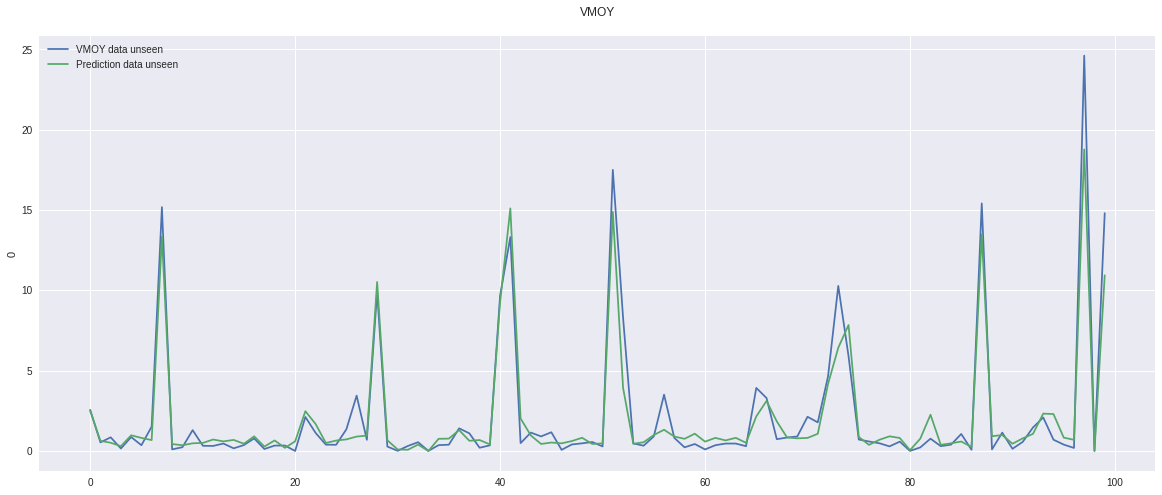

In [ ]:
plt.figure(figsize=(20,8))
sns.lineplot(range(100), data_unseen['VMOY'].iloc[200:300], label='VMOY data unseen') # pred_bird_1.shape[0]
sns.lineplot(range(100), y_pred_xgb_unseen[0].iloc[200:300], label='Prediction data unseen') # pred_bird_1.shape[0]
# sns.lineplot(range(100), pred_bird_2['VMOY'].iloc[:100], label='VMOY ') # pred_bird_1.shape[0]
# sns.lineplot(range(100), pred_bird_2['Label'].iloc[:100], label='Prediction') # pred_bird_1.shape[0]
# sns.lineplot(range(100), pred_bird_3['VMOY'].iloc[:100], label='VMOY bird 3') # pred_bird_1.shape[0]
# sns.lineplot(range(100), pred_bird_3['Label'].iloc[:100], label='Prediction bird 3') # pred_bird_1.shape[0]
plt.title("VMOY\n")
plt.show()

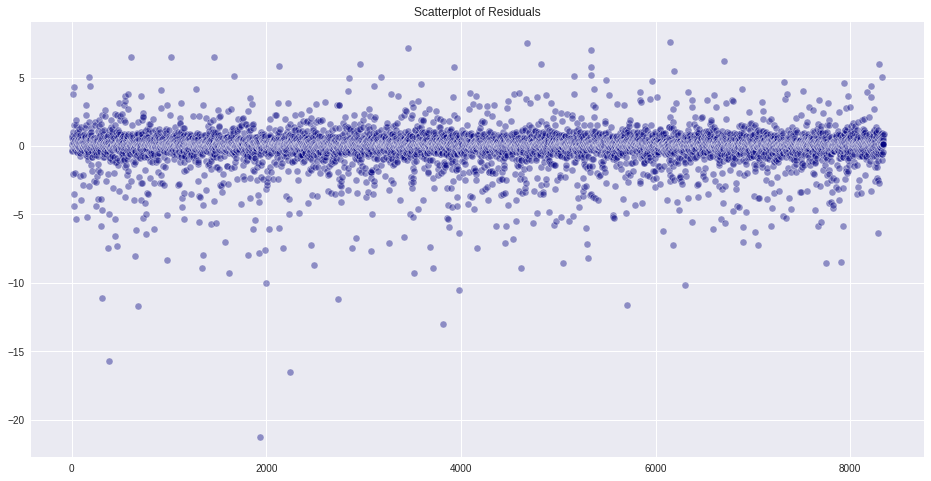

In [ ]:
residuals = y_pred_xgb_unseen[0] - data_unseen['VMOY']

plt.figure(figsize=(16,8))
sns.scatterplot(range(data_unseen.shape[0]), residuals, color='Navy', alpha=0.4)
plt.title("Scatterplot of Residuals")
plt.show()

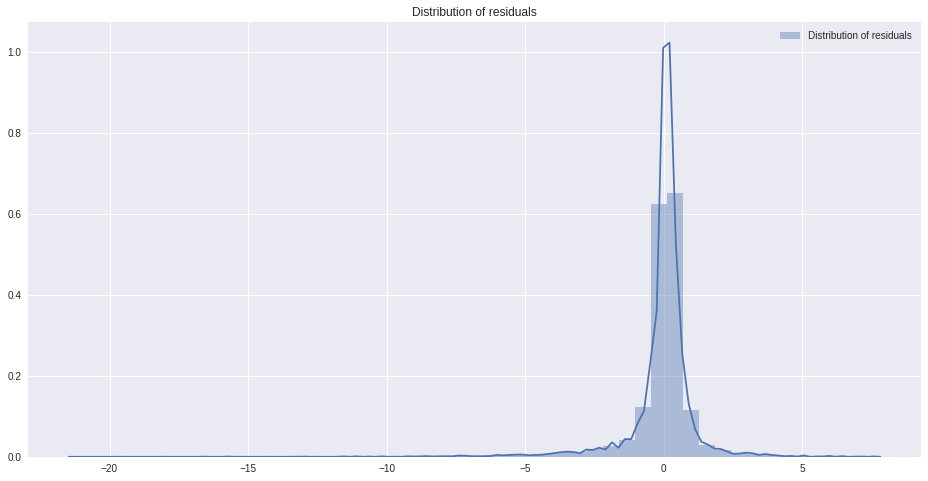

In [ ]:
residuals = y_pred_xgb_unseen[0] - data_unseen['VMOY']

plt.figure(figsize=(16,8))
sns.distplot(residuals, norm_hist=True, label='Distribution of residuals')
plt.title("Distribution of residuals")
plt.legend()
plt.show()

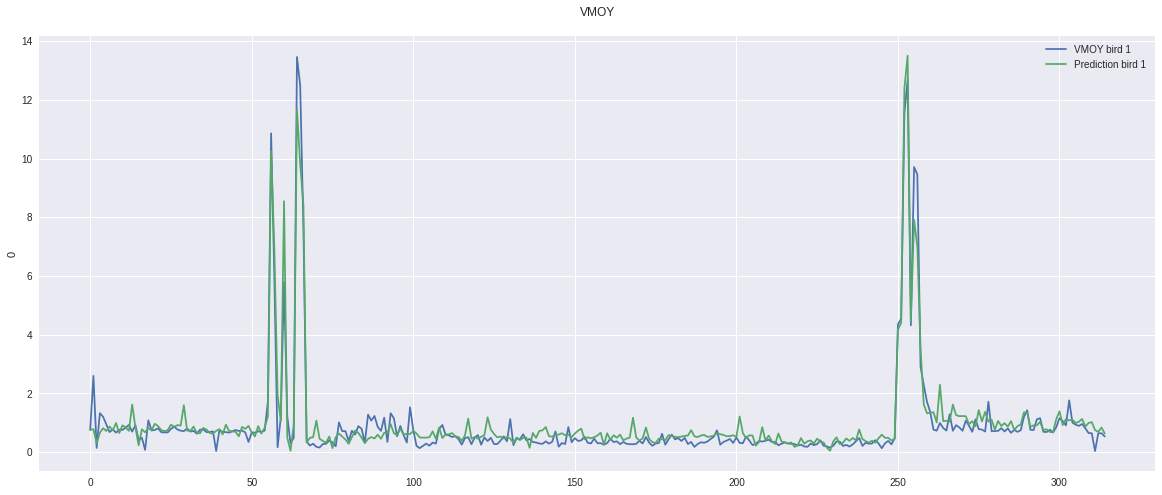

In [ ]:
plt.figure(figsize=(20,8))
sns.lineplot(range(df_bird_1.shape[0]), df_bird_1['VMOY'], label='VMOY bird 1', ) # pred_bird_1.shape[0]
sns.lineplot(range(df_bird_1.shape[0]), pred_bird_1_xgb[0], label='Prediction bird 1') # pred_bird_1.shape[0]
# sns.lineplot(range(100), pred_bird_2['VMOY'].iloc[:100], label='VMOY ') # pred_bird_1.shape[0]
# sns.lineplot(range(100), pred_bird_2['Label'].iloc[:100], label='Prediction') # pred_bird_1.shape[0]
# sns.lineplot(range(100), pred_bird_3['VMOY'].iloc[:100], label='VMOY bird 3') # pred_bird_1.shape[0]
# sns.lineplot(range(100), pred_bird_3['Label'].iloc[:100], label='Prediction bird 3') # pred_bird_1.shape[0]
plt.title("VMOY\n")
plt.show()

LIGHTGBM (oiseau isolé sur 2019)

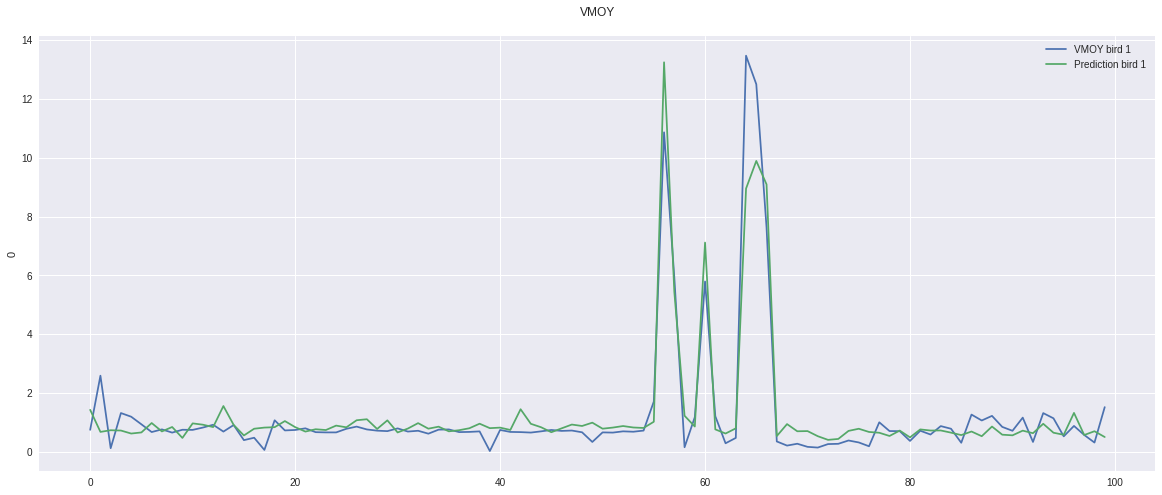

In [ ]:
plt.figure(figsize=(20,8))
sns.lineplot(range(100), df_bird_1['VMOY'].iloc[:100], label='VMOY bird 1') # pred_bird_1.shape[0]
sns.lineplot(range(100), pred_bird_1_lgbm[0].iloc[:100], label='Prediction bird 1') # pred_bird_1.shape[0]
# sns.lineplot(range(100), pred_bird_2['VMOY'].iloc[:100], label='VMOY ') # pred_bird_1.shape[0]
# sns.lineplot(range(100), pred_bird_2['Label'].iloc[:100], label='Prediction') # pred_bird_1.shape[0]
# sns.lineplot(range(100), pred_bird_3['VMOY'].iloc[:100], label='VMOY bird 3') # pred_bird_1.shape[0]
# sns.lineplot(range(100), pred_bird_3['Label'].iloc[:100], label='Prediction bird 3') # pred_bird_1.shape[0]
plt.title("VMOY\n")
plt.show()

## **Sauvegarde du modèle XGBOOST et chargement pour réutilisation**

In [ ]:
import pickle
# save the model to disk
filename = 'finalized_xgboost_model_20-06.sav'
pickle.dump(xgb_reg, open(filename, 'wb')) 

In [ ]:
import pickle
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result)

In [ ]:
# Making predictions

y_pred_xgb = pd.DataFrame(loaded_model.predict(data_unseen.drop('VMOY', axis=1)))
y_pred_xgb.describe()

## **Création et réglage du modèle Random Forest**

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.drop('VMOY', axis=1), data['VMOY'], test_size=0.2, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestRegressor, DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV

def rfr_model(X, y):
# Perform Grid-Search
    gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(3,7),
            'n_estimators': (10, 50, 100, 500),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=10, n_jobs=-1)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    
    rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"], random_state=125, verbose=True)
# Perform K-Fold CV
    scores = cross_val_score(rfr, X, y, cv=10, scoring='neg_mean_absolute_error')

    print('\n ==== Final Results ==== \n')

    return scores, rfr, best_params


In [ ]:
rfr_model(X_train, y_train)

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV

def dtr_model(X, y):
# Perform Grid-Search
    gsc = GridSearchCV(
        estimator=DecisionTreeRegressor(),
        param_grid={
            'max_depth': range(1,15),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=10, n_jobs=-1)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    
    dtr = DecisionTreeRegressor(max_depth=best_params["max_depth"], 
                                min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, presort='deprecated',
                                random_state=125, splitter='best')
# Perform K-Fold CV
    scores = cross_val_score(dtr, X, y, cv=10, scoring='neg_mean_absolute_error')

    print('\n ==== Final Results ==== \n')

    return scores, dtr, best_params
# 'min_samples_split': np.linspace(0.1, 1.0, 10, endpoint=True), min_samples_split=best_params["min_samples_split"],

In [ ]:
dtr_model(X_train, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1108s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.1018s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   18.1s finished



 ==== Final Results ==== 



(array([-0.58464583, -0.5916901 , -0.60070376, -0.5707226 , -0.55040975,
        -0.54754868, -0.59522934, -0.58825957, -0.56504479, -0.58302004]),
 DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=8,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=125, splitter='best'),
 {'max_depth': 8})

In [ ]:
dtr = DecisionTreeRegressor(max_depth=8, min_samples_leaf=1, min_samples_split=2,
                            min_weight_fraction_leaf=0.0, presort='deprecated',
                            random_state=125, splitter='best').fit(X_train, y_train)
# Perform K-Fold CV
scores = cross_val_score(dtr, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')
print(scores)

[-0.58464583 -0.5916901  -0.60070376 -0.5707226  -0.55040975 -0.54754868
 -0.59522934 -0.58825957 -0.56504479 -0.58302004]


In [ ]:
dtr.feature_importances_

array([0.16549809, 0.00512495, 0.02568237, 0.00361612, 0.02407759,
       0.00641294, 0.00789017, 0.00601952, 0.02994011, 0.00731844,
       0.00862737, 0.01642134, 0.00285322, 0.00446359, 0.00381407,
       0.00196039, 0.06028051, 0.05606282, 0.06573922, 0.37934587,
       0.1188513 ])

In [ ]:
names = 
names

Index(['month', 'day', 'TMP_surface', 'TMP_700mb', 'UGRD_10maboveground',
       'VGRD_10maboveground', 'UGRD_700mb', 'VGRD_700mb', 'PRES_surface',
       'PRMSL_meansealevel', 'PRATE_surface', 'RH_2maboveground',
       'Norme_Vent_10maboveground', 'Norme_Vent_700mb',
       'Angle_Vent_10maboveground', 'Angle_Vent_700mb', 'angle_oiseau',
       'location-lat-start', 'location-long-start', 'location-lat-end',
       'location-long-end'],
      dtype='object')

### **Importance des caractéristiques**

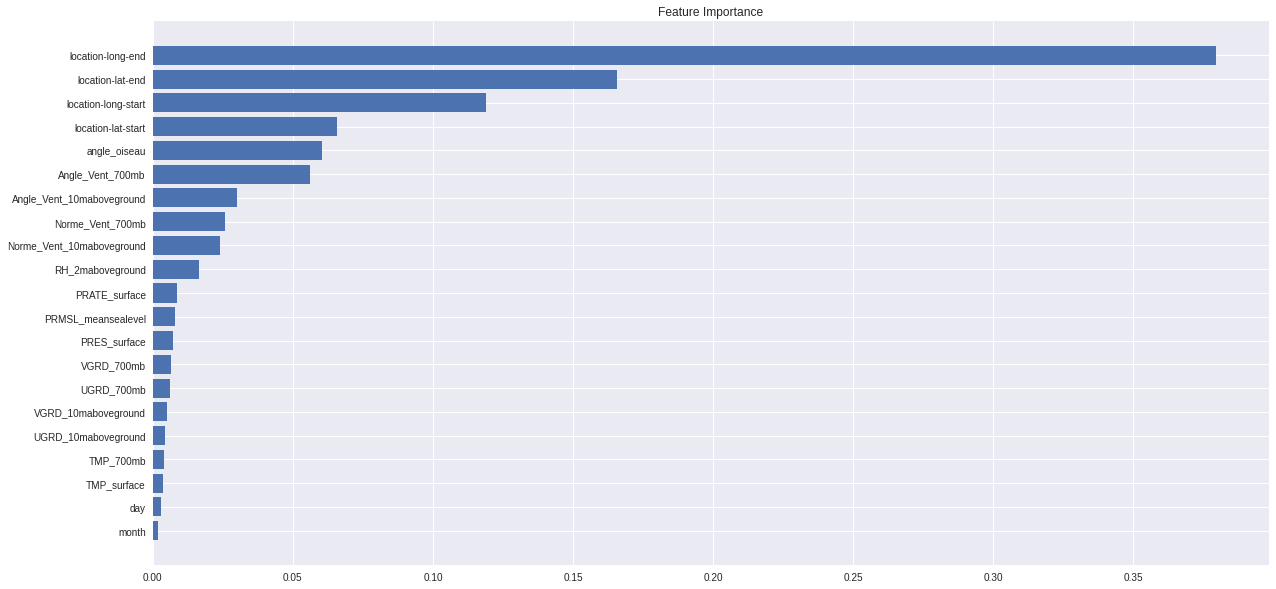

In [ ]:
# Calculate feature importances
importances = dtr.feature_importances_

# Sort feature importances in ascending order
indices = np.argsort(importances)[::]

# Rearrange feature names so they match the sorted feature importances
names = X_train.columns

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.barh(range(X_train.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.yticks(range(X_train.shape[1]), names, rotation=0)

# Show plot
plt.show()

### **Calcul des prédictions**

In [ ]:
pred_test = dtr.predict(X_test)
pred_test

array([0.91898876, 0.50262437, 0.72557826, ..., 0.72557826, 0.28603681,
       0.72557826])

In [ ]:
pred_test = pd.DataFrame(pred_test)
y_test = pd.DataFrame(y_test)

In [ ]:
pred_test.describe()

,0
count,6811.000000
mean,0.861757
std,0.546289
min,0.007989
25%,0.502624
50%,0.725578
75%,1.092608
max,7.089926


In [ ]:
y_test.describe()

,VMOY
count,6811.000000
mean,0.878961
std,0.991134
min,0.000002
25%,0.241157
50%,0.568544
75%,1.111897
max,7.671999


### **Affichage graphique des résultats**

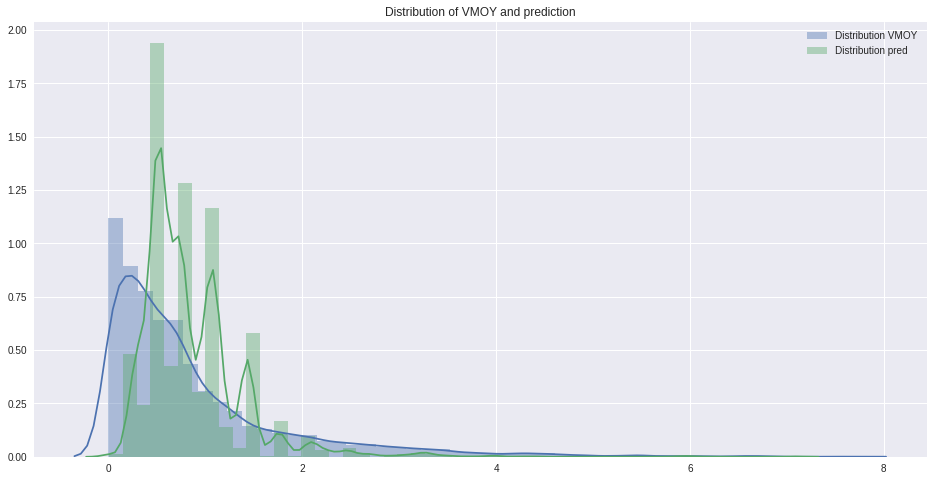

In [ ]:
plt.figure(figsize=(16,8))
sns.distplot(y_test, norm_hist=True, label='Distribution VMOY')
sns.distplot(pred_test, norm_hist=True, label='Distribution pred')
plt.title("Distribution of VMOY and prediction")
plt.legend()
plt.show()

In [ ]:
pred_bird_1 = pd.DataFrame(dtr.predict(df_bird_1.drop(['VMOY', 'tag-local-identifier', 'year'], axis=1)))
# pred_bird_2 = predict_model(model, data=df_bird_2)
# pred_bird_3 = predict_model(model, data=df_bird_3)

pred_bird_1.describe()

,0
count,315.000000
mean,0.697612
std,0.251901
min,0.286037
25%,0.502624
50%,0.725578
75%,0.749938
max,2.083262


In [ ]:
df_bird_1[['VMOY']].describe()

,VMOY
count,315.000000
mean,0.657814
std,0.554262
min,0.038025
25%,0.308398
50%,0.526112
75%,0.764508
max,4.210736


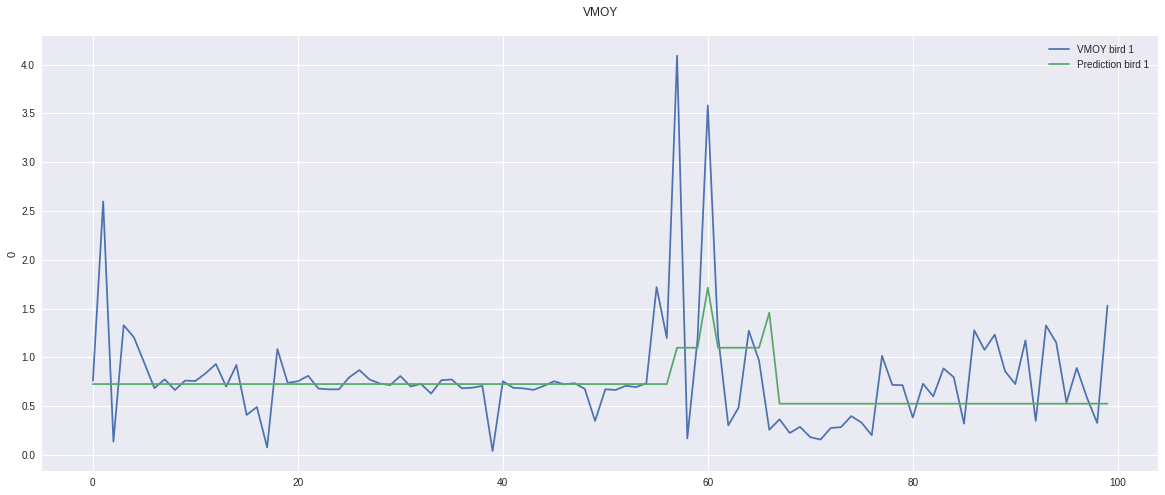

In [ ]:
plt.figure(figsize=(20,8))
sns.lineplot(range(100), df_bird_1['VMOY'].iloc[:100], label='VMOY bird 1') # pred_bird_1.shape[0]
sns.lineplot(range(100), pred_bird_1[0].iloc[:100], label='Prediction bird 1') # pred_bird_1.shape[0]
# sns.lineplot(range(100), pred_bird_2['VMOY'].iloc[:100], label='VMOY ') # pred_bird_1.shape[0]
# sns.lineplot(range(100), pred_bird_2['Label'].iloc[:100], label='Prediction') # pred_bird_1.shape[0]
# sns.lineplot(range(100), pred_bird_3['VMOY'].iloc[:100], label='VMOY bird 3') # pred_bird_1.shape[0]
# sns.lineplot(range(100), pred_bird_3['Label'].iloc[:100], label='Prediction bird 3') # pred_bird_1.shape[0]
plt.title("VMOY\n")
plt.show()

## **Création et réglage du modèle Extra Trees Regressor**

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.model_selection import cross_val_score, GridSearchCV

def etr_model(X, y):
# Perform Grid-Search
    gsc = GridSearchCV(
        estimator=ExtraTreesRegressor(),
        param_grid={
            'max_depth': range(5,15),
            'n_estimators': (100, 500, 800),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=10, n_jobs=-1)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    
    etr = ExtraTreesRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"], random_state=125, verbose=True)
# Perform K-Fold CV
    scores = cross_val_score(etr, X, y, cv=10, scoring='neg_mean_absolute_error')

    print('\n ==== Final Results ==== \n')

    return scores, etr, best_params

In [ ]:
etr_model(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   57.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed: 17


 ==== Final Results ==== 



(array([-0.9050864 , -0.88971628, -0.88231419, -0.89868219, -0.90792914,
        -0.86976219, -0.92378027, -0.97802212, -0.93854044, -0.93549032]),
 ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                     max_depth=14, max_features='auto', max_leaf_nodes=None,
                     max_samples=None, min_impurity_decrease=0.0,
                     min_impurity_split=None, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=500, n_jobs=None, oob_score=False,
                     random_state=125, verbose=True, warm_start=False),
 {'max_depth': 14, 'n_estimators': 500})

In [ ]:
etr = ExtraTreesRegressor(max_depth=14, n_estimators=500, random_state=125, verbose=True, n_jobs=-1).fit(X_train, y_train)
# Perform K-Fold CV
scores = cross_val_score(etr, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')
print(scores)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   15.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 116 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   16.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 164 tasks      |

[-0.9050864  -0.88971628 -0.88231419 -0.89868219 -0.90792914 -0.86976219
 -0.92378027 -0.97802212 -0.93854044 -0.93549032]


[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.2s finished


### **Importance des caractéristiques**

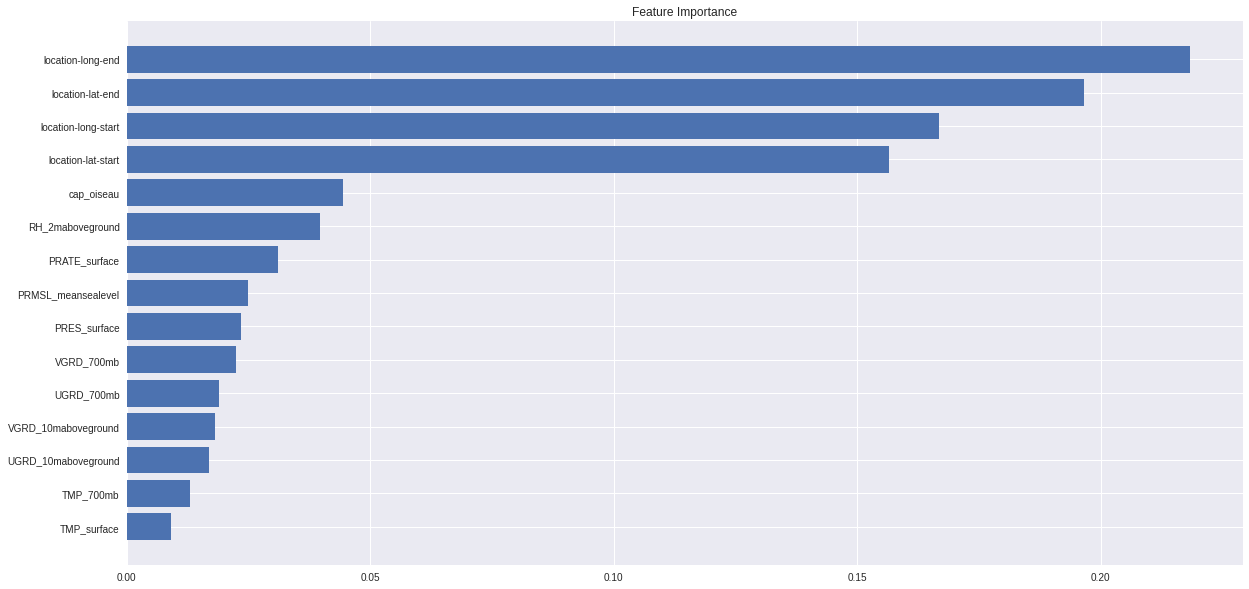

In [ ]:
# Calculate feature importances
importances = etr.feature_importances_

# Sort feature importances in ascending order
indices = np.argsort(importances)[::]

# Rearrange feature names so they match the sorted feature importances
names = X_train.columns

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.barh(range(X_train.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.yticks(range(X_train.shape[1]), names, rotation=0)

# Show plot
plt.show()

### **Calcul des prédictions**

In [ ]:
pred_test = etr.predict(X_test)
pred_test

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.4s finished


array([0.78725038, 0.80544993, 0.76273602, ..., 0.84730549, 0.92256146,
       0.92233528])

In [ ]:
pred_test = pd.DataFrame(pred_test)
y_test = pd.DataFrame(y_test)

### **Scores**

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mae = mean_absolute_error(y_test, pred_test)
mse = mean_squared_error(y_test, pred_test)
r2 = r2_score(y_test, pred_test)
print("MAE: %f" % (mae))
print("MSE: %f" % (mse))
print("R2: %f" % (r2))

MAE: 0.928998
MSE: 2.743651
R2: 0.671551


### **Affichage graphique des résultats**

In [ ]:
pred_test.describe()

,0
count,6697.000000
mean,1.489213
std,1.877304
min,0.090779
25%,0.787256
50%,0.936456
75%,1.268615
max,19.644781


In [ ]:
y_test.describe()

,VMOY
count,6697.000000
mean,1.530037
std,2.890435
min,0.000060
25%,0.262329
50%,0.592457
75%,1.216793
max,25.604405


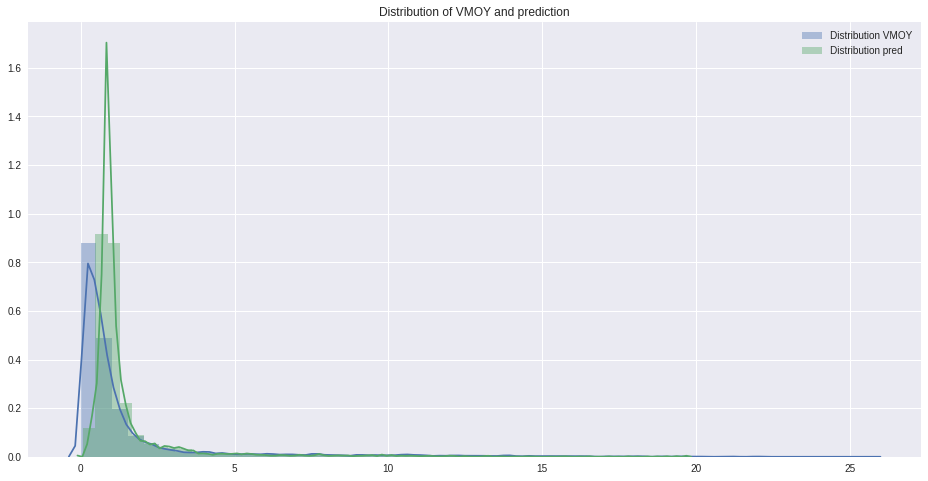

In [ ]:
plt.figure(figsize=(16,8))
sns.distplot(y_test, norm_hist=True, label='Distribution VMOY')
sns.distplot(pred_test, norm_hist=True, label='Distribution pred')
plt.title("Distribution of VMOY and prediction")
plt.legend()
plt.show()

In [ ]:
pred_bird_1 = pd.DataFrame(etr.predict(df_bird_1.drop(['VMOY', 'tag-local-identifier', 'year', 'month', 'day', 
                                                                 'Norme_Vent_10maboveground',	'Norme_Vent_700mb',	
                                                                 'Angle_Vent_10maboveground', 'Angle_Vent_700mb'], axis=1)))
# pred_bird_2 = predict_model(model, data=df_bird_2)
# pred_bird_3 = predict_model(model, data=df_bird_3)

pred_bird_1.describe()

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.2s finished


,0
count,315.000000
mean,1.057722
std,1.190506
min,0.592119
25%,0.744030
50%,0.763832
75%,1.008060
max,11.454789


In [ ]:
df_bird_1[['VMOY']].describe()

,VMOY
count,315.000000
mean,0.922916
std,1.782974
min,0.038025
25%,0.311182
50%,0.529977
75%,0.765926
max,13.460609


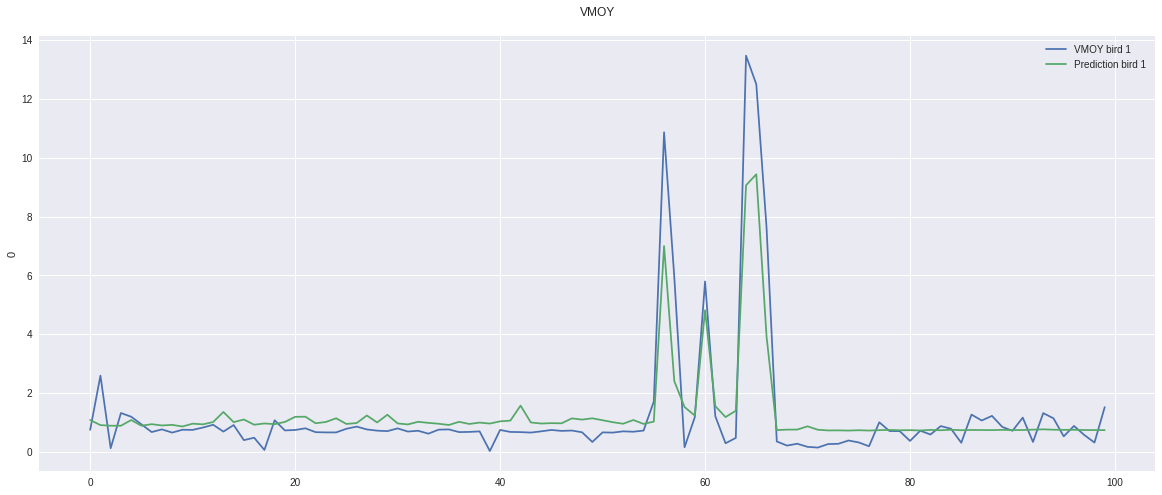

In [ ]:
plt.figure(figsize=(20,8))
sns.lineplot(range(100), df_bird_1['VMOY'].iloc[:100], label='VMOY bird 1') # pred_bird_1.shape[0]
sns.lineplot(range(100), pred_bird_1[0].iloc[:100], label='Prediction bird 1') # pred_bird_1.shape[0]
# sns.lineplot(range(100), pred_bird_2['VMOY'].iloc[:100], label='VMOY ') # pred_bird_1.shape[0]
# sns.lineplot(range(100), pred_bird_2['Label'].iloc[:100], label='Prediction') # pred_bird_1.shape[0]
# sns.lineplot(range(100), pred_bird_3['VMOY'].iloc[:100], label='VMOY bird 3') # pred_bird_1.shape[0]
# sns.lineplot(range(100), pred_bird_3['Label'].iloc[:100], label='Prediction bird 3') # pred_bird_1.shape[0]
plt.title("VMOY\n")
plt.show()